# Capstone: College to NBA Player Performance Prediction

## Introduction

**Preamble:**

 From a business perspective, NBA drafts have been notorious crapshoots where it is not uncommon for players drafted from college to end up underperforming their expectated value. This a huge waste of organizational investment in terms of time and money, not to mention the opportunity cost of a better replacement player. Thus, being able to determine a college player's likelihood of being performant in the NBA becomes a valuable tool for teams when investing in new talent direct from college.

**Data Sources:**

[College Basketball 2009-2021 + NBA Advanced Stats](https://www.kaggle.com/datasets/adityak2003/college-basketball-players-20092021): 
- **Description**: Contains college statistics from 2009-2021 + advanced NBA stats from 2014-2022. 
- **Rationale**: This source will provide the college performance data to be used as the independent variables.

[20 Years of NBA Draft Data](https://www.kaggle.com/datasets/benwieland/nba-draft-data): 
- **Description**: NBA statistics for every pick, along with NCAA stat page links for data scraping. 
- **Rationale**: This source will provide the list of college players who were drafted into the NBA. This will be the primary source on which the college statistics will be merged against. Additionally, the NBA statistics cover the length of each players career to date which will be used as inputs to our dependent variable.

**Table of Contents:**

- [Data Preparation](##Data-Preparation)
- [Data Exploration](##Data-Exploration)
- [Model Preprocessing](##Model-Preprocessing)
- [Model Training & Eval Part 1](##Model-Training-&-Eval-Part-1)
- [Model Training & Eval Part 2](##Model-Training-&-Eval-Part-2)
- [Model Results Summary](##Model-Results-Summary)
- [Model Interpretation](##Model-Interpretation)
- [Model Predictions](##Model-Predictions)

### Imports

In [2]:
# Add environment variable to handle MKL known issue causing kernel crash for KNN
from dotenv import load_dotenv
load_dotenv()

# Add warning class to suppress warnings for readability
import warnings
warnings.filterwarnings("ignore")

# Add os import to reliabily propagate this filter to child processes 
# (when running multiprocessing/parallelism)
import os
os.environ["PYTHONWARNINGS"] = "ignore"

In [3]:
# Create imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## Data Preparation

[Back to Top](##Introduction)

### Set 1: College Basketball
We will first bring in both College Basketball and NBA Draft Data datasets in order to combine them into a single dataset for use in our predictive model. Note we will postpone any exploration until this is complete.

In [4]:
# load in the College Basketball dataset
college = pd.read_csv('data/college/CollegeBasketballPlayers2009-2021.csv')

In [5]:
college.columns

Index(['player_name', 'team', 'conf', 'GP', 'Min_per', 'Ortg', 'usg', 'eFG',
       'TS_per', 'ORB_per', 'DRB_per', 'AST_per', 'TO_per', 'FTM', 'FTA',
       'FT_per', 'twoPM', 'twoPA', 'twoP_per', 'TPM', 'TPA', 'TP_per',
       'blk_per', 'stl_per', 'ftr', 'yr', 'ht', 'num', 'porpag', 'adjoe',
       'pfr', 'year', 'pid', 'type', 'Rec Rank', 'ast/tov', 'rimmade',
       'rimmade+rimmiss', 'midmade', 'midmade+midmiss',
       'rimmade/(rimmade+rimmiss)', 'midmade/(midmade+midmiss)', 'dunksmade',
       'dunksmiss+dunksmade', 'dunksmade/(dunksmade+dunksmiss)', 'pick',
       'drtg', 'adrtg', 'dporpag', 'stops', 'bpm', 'obpm', 'dbpm', 'gbpm',
       'mp', 'ogbpm', 'dgbpm', 'oreb', 'dreb', 'treb', 'ast', 'stl', 'blk',
       'pts', 'Unnamed: 64', 'Unnamed: 65'],
      dtype='object')

In [6]:
# view more columns at once
pd.set_option('display.max_columns', 500)

In [7]:
# this is a manually pieced together view of the column descriptions
data_dictionary = {
'player_name' : 'Player name', 
'team': 'Team', 
'conf': 'Conference', 
'GP' : 'Games played', 
'Min_per' : 'Minutes %', 
'Ortg' : 'Offensive rating', 
'usg' : 'Usage', 
'eFG' : 'Effective field goal %',
'TS_per' : 'True shooting %', 
'ORB_per' : 'Offensive rebound %', 
'DRB_per' : 'Defensive rebound %', 
'AST_per' : 'Assist %', 
'TO_per' : 'Turnover %', 
'FTM' : 'Free throws made', 
'FTA' : 'Free throws attempted',
'FT_per' : 'Free throws %', 
'twoPM' : '2-pointers made', 
'twoPA' : '2-pointers attempted', 
'twoP_per' : '2-pointers %', 
'TPM' : '3-pointers made', 
'TPA' : '3-pointers attempted', 
'TP_per': '3-pointers %',
'blk_per': 'Block %', 
'stl_per': 'Steal %', 
'ftr': 'Free throw rate', 
'yr' : 'Year of college', 
'ht' : 'ht',
'num' : 'num', # drop
'porpag': 'Pointers over replacement per adjusted game', 
'adjoe': 'Adjusted offensive efficiency',
'pfr': 'pfr', 
'year' : 'Year', 
'pid' : 'Player ID (recurring for each year)', 
'type' : 'Type', 
'Rec Rank' : 'Recruit Rank', # drop (introduces bias) 
'ast/tov' : 'Assist / Turnover ratio',
'rimmade' : 'Rim shots made',
'rimmade+rimmiss': 'Rim shots attempted', 
'midmade' : 'Midrange shots made', 
'midmade+midmiss' : 'Midrange shots attempted',
'rimmade/(rimmade+rimmiss)' : 'Rim shots %', 
'midmade/(midmade+midmiss)' : 'Midrange shots %', 
'dunksmade' : 'Dunks made',
'dunksmiss+dunksmade' : 'Dunks attempted', 
'dunksmade/(dunksmade+dunksmiss)' : 'Dunks %', 
'pick' : 'Pick drafted', # drop (introduces bias)
'drtg' : 'Defensive rating', 
'adrtg' : 'Adjusted defensive rating', 
'dporpag' : 'Defensive points over replacement per adjusted game', 
'stops' : 'Stops', 
'bpm' : 'Box plus/minus', 
'obpm' : 'Offensive box plus/minus', 
'dbpm' : 'Defensive box plus/minus', 
'gbpm' : 'gbpm',
'mp' : 'Minutes played', 
'ogbpm' : 'Offensive gbpm', 
'dgbpm' : 'Defensive gbpm', 
'oreb' : 'Offensive rebounds', 
'dreb' : 'Defensive rebounds', 
'treb' : 'Total rebounds', 
'ast' : 'Assists', 
'stl' : 'Steals', 
'blk' : 'Blocks',
'pts' : 'Points',
}
pd.DataFrame.from_dict(data_dictionary, columns = ['desc'], orient='index').T

,player_name,team,conf,GP,Min_per,Ortg,usg,eFG,TS_per,ORB_per,DRB_per,AST_per,TO_per,FTM,FTA,FT_per,twoPM,twoPA,twoP_per,TPM,TPA,TP_per,blk_per,stl_per,ftr,yr,ht,num,porpag,adjoe,pfr,year,pid,type,Rec Rank,ast/tov,rimmade,rimmade+rimmiss,midmade,midmade+midmiss,rimmade/(rimmade+rimmiss),midmade/(midmade+midmiss),dunksmade,dunksmiss+dunksmade,dunksmade/(dunksmade+dunksmiss),pick,drtg,adrtg,dporpag,stops,bpm,obpm,dbpm,gbpm,mp,ogbpm,dgbpm,oreb,dreb,treb,ast,stl,blk,pts
desc,Player name,Team,Conference,Games played,Minutes %,Offensive rating,Usage,Effective field goal %,True shooting %,Offensive rebound %,Defensive rebound %,Assist %,Turnover %,Free throws made,Free throws attempted,Free throws %,2-pointers made,2-pointers attempted,2-pointers %,3-pointers made,3-pointers attempted,3-pointers %,Block %,Steal %,Free throw rate,Year of college,ht,num,Pointers over replacement per adjusted game,Adjusted offensive efficiency,pfr,Year,Player ID (recurring for each year),Type,Recruit Rank,Assist / Turnover ratio,Rim shots made,Rim shots attempted,Midrange shots made,Midrange shots attempted,Rim shots %,Midrange shots %,Dunks made,Dunks attempted,Dunks %,Pick drafted,Defensive rating,Adjusted defensive rating,Defensive points over replacement per adjusted...,Stops,Box plus/minus,Offensive box plus/minus,Defensive box plus/minus,gbpm,Minutes played,Offensive gbpm,Defensive gbpm,Offensive rebounds,Defensive rebounds,Total rebounds,Assists,Steals,Blocks,Points


In [8]:
college.head()

,player_name,team,conf,GP,Min_per,Ortg,usg,eFG,TS_per,ORB_per,DRB_per,AST_per,TO_per,FTM,FTA,FT_per,twoPM,twoPA,twoP_per,TPM,TPA,TP_per,blk_per,stl_per,ftr,yr,ht,num,porpag,adjoe,pfr,year,pid,type,Rec Rank,ast/tov,rimmade,rimmade+rimmiss,midmade,midmade+midmiss,rimmade/(rimmade+rimmiss),midmade/(midmade+midmiss),dunksmade,dunksmiss+dunksmade,dunksmade/(dunksmade+dunksmiss),pick,drtg,adrtg,dporpag,stops,bpm,obpm,dbpm,gbpm,mp,ogbpm,dgbpm,oreb,dreb,treb,ast,stl,blk,pts,Unnamed: 64,Unnamed: 65
0,DeAndrae Ross,South Alabama,SB,26,29.5,97.3,16.6,42.5,44.43,1.6,4.6,15.8,16.3,10,14,0.714,26,68,0.382,13,39,0.333,0.3,1.5,13.1,So,2-Jun,NaN,0.258086,89.3938,2.5,2009,2,all,NaN,1.823646,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,108.321,108.527,0.893017,49.9644,-4.995140,-1.623360,-3.371780,-4.723150,14.5769,-2.781990,-1.941150,0.1923,0.6154,0.8077,1.1923,0.3462,0.0385,3.8846,NaN,6.22026
1,Pooh Williams,Utah St.,WAC,34,60.9,108.3,14.9,52.4,54.48,3.8,6.3,13.6,19.8,30,45,0.667,56,113,0.496,20,51,0.392,1.0,1.1,27.4,So,4-Jun,NaN,1.334920,100.0660,3.4,2009,3,all,NaN,1.631621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,105.078,104.017,1.880030,111.9290,0.593024,1.385490,-0.792469,-0.300196,24.5294,-0.052263,-0.247934,0.6765,1.2647,1.9412,1.8235,0.4118,0.2353,5.9412,NaN,3.94375
2,Jesus Verdejo,South Florida,BE,27,72.0,96.2,21.8,45.7,47.98,2.1,8.0,14.7,15.9,45,67,0.672,67,157,0.427,50,154,0.325,0.0,0.9,21.5,Sr,4-Jun,NaN,2.274070,104.1070,1.7,2009,5,all,NaN,1.081662,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.556,102.154,2.763870,115.0210,0.003161,1.024770,-1.021610,0.665065,33.1852,1.548230,-0.883163,0.6296,2.3333,2.9630,1.9630,0.4815,0.0000,12.1852,NaN,10.92680
3,Mike Hornbuckle,Pepperdine,WCC,30,44.5,97.7,16.0,53.6,53.69,4.1,9.4,13.7,23.8,14,27,0.519,25,63,0.397,28,62,0.452,0.8,1.9,21.6,Sr,4-Jun,NaN,0.552857,93.2086,2.0,2009,8,all,NaN,0.942830,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,108.858,106.556,1.218710,84.1698,-0.977798,-0.502574,-0.475224,-0.736233,17.9667,-0.342775,-0.393459,0.7000,1.4333,2.1333,1.1000,0.5667,0.1333,4.9333,NaN,6.77427
4,Anthony Brown,Pacific,BW,33,56.2,96.5,22.0,52.8,54.31,8.3,18.6,8.2,22.7,64,114,0.561,93,176,0.528,0,0,0.000,1.9,1.3,64.8,Sr,8-Jun,NaN,1.060130,97.8554,3.8,2009,9,all,NaN,0.491229,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,101.052,100.724,1.992790,128.0280,-1.836060,-1.946040,0.109983,-2.353180,22.9091,-1.684860,-0.668318,1.4242,3.3030,4.7273,0.8485,0.4545,0.3333,7.5758,NaN,0.00000


In [9]:
# spot checking nulls
college[college['year'] >= 2009].isnull().sum().to_frame().nlargest(40, columns = 0).T

,pick,Rec Rank,dunksmade/(dunksmade+dunksmiss),midmade/(midmade+midmiss),rimmade/(rimmade+rimmiss),rimmade,rimmade+rimmiss,midmade,midmade+midmiss,dunksmade,dunksmiss+dunksmade,num,ast/tov,Unnamed: 64,yr,ht,drtg,adrtg,dporpag,stops,bpm,obpm,dbpm,gbpm,ogbpm,dgbpm,Unnamed: 65,mp,oreb,dreb,treb,ast,stl,blk,pts,player_name,team,conf,GP,Min_per
0,59626,42591,33510,10385,10110,6329,6329,6329,6329,6329,6329,4786,4727,4684,294,111,45,45,45,45,45,45,45,45,45,45,45,38,38,38,38,38,38,38,38,0,0,0,0,0


A few things worth noting on missing values: 
- pick and recruitment rank: understandable as not all players are recruited/picked
- for majority of advanced statistics: data source claims some are only available after 2014

We will not make any changes yet as our final dataset will only be a small subset. Any missing values will be dealt with once we have joined it with the NBA Draft dataset.

### Set 2: NBA Draft dataset
Next we will bring in the NBA Draft dataset which will be our primary dataset. We will perform a join of the previous College Basketball dataset with this.

In [10]:
# load the NBA Draft dataset
draft_bw = pd.read_csv('data/draft/draft-data-20-years.csv', index_col=0)
draft_bw.head()

,Rk,Pk,Tm,Player,College,Yrs,G,TOTMP,TOTPTS,TOTTRB,TOTAST,FG%,3P%,FT%,WS,WS/48,BPM,VORP,DraftYr,MPG,PPG,RPG,APG,playerurl,DraftYear
1,1,1,BRK,Derrick Coleman,Syracuse,15.0,781.0,25903.0,12884.0,7232.0,1985.0,0.447,0.295,0.769,64.3,0.119,1.4,22.3,1990,33.2,16.5,9.3,2.5,https://www.sports-reference.com/cbb/players/d...,1990
2,2,2,OKC,Gary Payton,Oregon State,17.0,1335.0,47117.0,21813.0,5269.0,8966.0,0.466,0.317,0.729,145.5,0.148,3.3,62.5,1990,35.3,16.3,3.9,6.7,https://www.sports-reference.com/cbb/players/g...,1990
3,3,3,DEN,Mahmoud Abdul-Rauf,LSU,9.0,586.0,15628.0,8553.0,1087.0,2079.0,0.442,0.354,0.905,25.2,0.077,-0.8,4.5,1990,26.7,14.6,1.9,3.5,https://www.sports-reference.com/cbb/players/m...,1990
4,4,4,ORL,Dennis Scott,Georgia Tech,10.0,629.0,17983.0,8094.0,1774.0,1296.0,0.417,0.397,0.793,33.4,0.089,0.2,9.9,1990,28.6,12.9,2.8,2.1,https://www.sports-reference.com/cbb/players/d...,1990
5,5,5,CHA,Kendall Gill,Illinois,15.0,966.0,29481.0,12914.0,4002.0,2945.0,0.434,0.300,0.754,47.8,0.078,0.1,15.8,1990,30.5,13.4,4.1,3.0,https://www.sports-reference.com/cbb/players/k...,1990


In [11]:
# rename our columns for nba career data to differentiate against college stats
column_dict = {}
for column in draft_bw.columns:
    column_dict[column] = 'nba_' + column

# then remove the ones that don't need the renaming
column_dict.pop('Player')
column_dict.pop('College')
column_dict.pop('DraftYr')
column_dict.pop('playerurl')

# then rename the columns
draft_bw.rename(columns = column_dict, inplace=True)
draft_bw.head()

,nba_Rk,nba_Pk,nba_Tm,Player,College,nba_Yrs,nba_G,nba_TOTMP,nba_TOTPTS,nba_TOTTRB,nba_TOTAST,nba_FG%,nba_3P%,nba_FT%,nba_WS,nba_WS/48,nba_BPM,nba_VORP,DraftYr,nba_MPG,nba_PPG,nba_RPG,nba_APG,playerurl,nba_DraftYear
1,1,1,BRK,Derrick Coleman,Syracuse,15.0,781.0,25903.0,12884.0,7232.0,1985.0,0.447,0.295,0.769,64.3,0.119,1.4,22.3,1990,33.2,16.5,9.3,2.5,https://www.sports-reference.com/cbb/players/d...,1990
2,2,2,OKC,Gary Payton,Oregon State,17.0,1335.0,47117.0,21813.0,5269.0,8966.0,0.466,0.317,0.729,145.5,0.148,3.3,62.5,1990,35.3,16.3,3.9,6.7,https://www.sports-reference.com/cbb/players/g...,1990
3,3,3,DEN,Mahmoud Abdul-Rauf,LSU,9.0,586.0,15628.0,8553.0,1087.0,2079.0,0.442,0.354,0.905,25.2,0.077,-0.8,4.5,1990,26.7,14.6,1.9,3.5,https://www.sports-reference.com/cbb/players/m...,1990
4,4,4,ORL,Dennis Scott,Georgia Tech,10.0,629.0,17983.0,8094.0,1774.0,1296.0,0.417,0.397,0.793,33.4,0.089,0.2,9.9,1990,28.6,12.9,2.8,2.1,https://www.sports-reference.com/cbb/players/d...,1990
5,5,5,CHA,Kendall Gill,Illinois,15.0,966.0,29481.0,12914.0,4002.0,2945.0,0.434,0.300,0.754,47.8,0.078,0.1,15.8,1990,30.5,13.4,4.1,3.0,https://www.sports-reference.com/cbb/players/k...,1990


In [12]:
# keep note of how many NBA draft players
draft_bw.shape

(1868, 25)

### Left join on datasets
It would seem straightforward to perform an inner join where every NBA Draft dataset player has matching record(s) in the College Basketball dataset. Unfortunately a few issues exist (not shown here for brevity):
- There is no common player ID to join by
- Multiple players share the same name (different colleges)
- Not all college names are formatted the same

This yields a less than ideal series of steps below to join the datasets. In the future, either a better dataset or improved way of joining may be reconsidered.

Approach: Try left join by only player name to capture the most matches and then systematically cleaning up incorrect matches.

In [13]:
# only select 2009 onwards as we only have college data for these players
draft_2009_2021 = draft_bw[draft_bw['DraftYr']>=2009]
draft_2009_2021.shape

(780, 25)

In [14]:
# join the college data for these players
draft_college_stats = pd.merge(left = draft_2009_2021, right = college, how = 'left', left_on = ['Player'], right_on = ['player_name'])
draft_college_stats.shape

(1675, 91)

In [15]:
# observe the duplicates and where we need to clean up
draft_college_stats[['Player', 'College', 'DraftYr', 'playerurl', 'team', 'conf', 'yr', 'year']][draft_college_stats.duplicated(subset = ['Player'])].groupby(['Player']).count().nlargest(20, 'DraftYr')
#draft_college_stats['Player'].value_counts().to_frame().nlargest(20, 'count')

,College,DraftYr,playerurl,team,conf,yr,year
Player,,,,,,,
Justin Jackson,21,21,21,21,21,21,21
Marcus Thornton,19,19,19,19,19,19,19
Cameron Johnson,13,13,13,13,13,13,13
Jalen Johnson,11,11,11,11,11,11,11
James Johnson,10,10,10,10,10,10,10
Anthony Brown,8,8,8,8,8,8,8
Jalen Harris,8,8,8,8,8,8,8
Jordan Williams,8,8,8,8,8,8,8
Mike Scott,7,7,7,7,7,7,7


In [16]:
# focus on the top 16 trouble players as it doesn't pass the sniff test
# ie. they cannot have more than 4 years of college statistics
trouble_players = draft_college_stats[['Player', 'College', 'DraftYr', 'playerurl', 'team', 'conf', 'yr', 'year']][draft_college_stats.duplicated(subset = ['Player'])].groupby(['Player']).count().nlargest(16, 'DraftYr').index.to_list()
trouble_players

['Justin Jackson',
 'Marcus Thornton',
 'Cameron Johnson',
 'Jalen Johnson',
 'James Johnson',
 'Anthony Brown',
 'Jalen Harris',
 'Jordan Williams',
 'Mike Scott',
 'Isaiah Thomas',
 'Jordan Bell',
 'Jordan McRae',
 'Derrick Williams',
 'Jordan Hamilton',
 'Kyle Anderson',
 'Robert Williams']

In [17]:
# view the duplicates in detail for these players
pd.set_option('display.max_rows', 100)
draft_college_stats[draft_college_stats['Player'].isin(trouble_players)].groupby(['Player', 'College', 'team']).count()[['DraftYr']]

DraftYr
Player           College        team                          
Anthony Brown    Stanford       Green Bay                    1
                                Oklahoma St.                 1
                                Pacific                      1
                                Stanford                     5
                                Washington St.               1
Cameron Johnson  UNC            College of Charleston        4
                                North Carolina               2
                                Pittsburgh                   3
                                Stephen F. Austin            2
                                Texas St.                    3
Derrick Williams Arizona        Arizona                      2
                                Richmond                     4
Isaiah Thomas    Washington     Northern Arizona             4
                                Washington                   3
Jalen Harris     Nevada         Arkansas                     2
                                Army                         1
                                Cal St. Fullerton            1
                                Georgetown                   1
                                Louisiana Tech               2
                                Nevada                       1
                                New Mexico                   1
Jalen Johnson    Duke           Alabama A&M                  2
                                Duke                         1
                                Louisiana Lafayette          1
                                Mississippi St.              1
                                Murray St.                   1
                                Saint Louis                  2
                                Tennessee                    3
                                Wake Forest                  1
James Johnson    Wake Forest    Cal St. Fullerton            1
                                Liberty                      1
                                Louisiana Tech               1
                                Quinnipiac                   4
                                San Diego St.                2
                                Virginia                     1
                                Wake Forest                  1
Jordan Bell      Oregon         Loyola Marymount             2
                                Northwestern St.             1
                                Oregon                       3
                                Pacific                      1
Jordan Hamilton  Texas          Lehigh                       4
                                Texas                        2
Jordan McRae     Tennessee      Binghamton                   3
                                Tennessee                    4
Jordan Williams  Maryland       Maryland                     2
                                North Texas                  4
                                St. Francis NY               3
Justin Jackson   Maryland       Cincinnati                   4
                                Maryland                     2
                                Morgan St.                   1
                                North Carolina               3
                                Tennessee                    1
                 UNC            Cincinnati                   4
                                Maryland                     2
                                Morgan St.                   1
                                North Carolina               3
                                Tennessee                    1
Kyle Anderson    UCLA           Delaware                     4
                                UCLA                         2
Marcus Thornton  LSU            Georgia                      5
                                LSU                          1
                                William & Mary               4
                 Willia

Since most of the duplicates are due to shared names between players from different colleges, we can drop the combinations (player name/college/team) that are incorrect iteratively until we exhaust all the incorrect matches.

In [18]:
# track the row count prior
draft_college_stats.shape

(1675, 91)

In [19]:
# make a list of the combinations we need to drop
drop_list = draft_college_stats[draft_college_stats['Player'].isin(trouble_players)].groupby(['Player', 'College', 'team']).count()[['DraftYr']].index.to_list()
drop_list[:10]

[('Anthony Brown', 'Stanford', 'Green Bay'),
 ('Anthony Brown', 'Stanford', 'Oklahoma St.'),
 ('Anthony Brown', 'Stanford', 'Pacific'),
 ('Anthony Brown', 'Stanford', 'Stanford'),
 ('Anthony Brown', 'Stanford', 'Washington St.'),
 ('Cameron Johnson', 'UNC', 'College of Charleston'),
 ('Cameron Johnson', 'UNC', 'North Carolina'),
 ('Cameron Johnson', 'UNC', 'Pittsburgh'),
 ('Cameron Johnson', 'UNC', 'Stephen F. Austin'),
 ('Cameron Johnson', 'UNC', 'Texas St.')]

In [20]:
# update the list to not drop where the college/teams names do match
drop_list_1 = []
for p_name, c_name, c_name2 in drop_list:
    if c_name != c_name2:
        drop_list_1.append([p_name, c_name, c_name2])
drop_list_1[:10]

[['Anthony Brown', 'Stanford', 'Green Bay'],
 ['Anthony Brown', 'Stanford', 'Oklahoma St.'],
 ['Anthony Brown', 'Stanford', 'Pacific'],
 ['Anthony Brown', 'Stanford', 'Washington St.'],
 ['Cameron Johnson', 'UNC', 'College of Charleston'],
 ['Cameron Johnson', 'UNC', 'North Carolina'],
 ['Cameron Johnson', 'UNC', 'Pittsburgh'],
 ['Cameron Johnson', 'UNC', 'Stephen F. Austin'],
 ['Cameron Johnson', 'UNC', 'Texas St.'],
 ['Derrick Williams', 'Arizona', 'Richmond']]

In [21]:
len(drop_list_1)

54

We also note that Justin Jackson and Cameron Johnson have their college names formatted different between the two sources (UNC vs North Carolina), so we will be careful to remove them from the drop list as well.

In [22]:
# this leaves only
# 1) Justin Jackson - UNC / North Carolina mismatch
# 2) Cameron Johnson - UNC / North Carolina mismatch
# we'll manually remove these two 'valid' misatches
remove_jj = ['Justin Jackson', 'UNC', "North Carolina"]
remove_cj = ['Cameron Johnson', 'UNC', "North Carolina"]
drop_list_1.remove(remove_jj)
drop_list_1.remove(remove_cj)
len(drop_list_1)

52

The following will apply the drop list above, wherein we drop the combination of player/college/team that were misatched to our dataset during the left join.

In [23]:
# for brevity this section of code will be looped until we have removed the above cases of incorrect matches
# we will check the shape to ensure the right amount of rows is removed

for p_name, c_name, c_name2 in drop_list_1:
    # keep only the portion of dataframe that doesn't include the drop list combination
    draft_college_stats = draft_college_stats[~((draft_college_stats['Player'] == p_name) & (draft_college_stats['College'] == c_name) & (draft_college_stats['team'] == c_name2))]

draft_college_stats.shape

(1560, 91)

In [24]:
# sanity check
draft_college_stats[draft_college_stats['Player'].isin(trouble_players)].groupby(['Player', 'College', 'team']).count()[['DraftYr']]

,,,DraftYr
Player,College,team,
Anthony Brown,Stanford,Stanford,5
Cameron Johnson,UNC,North Carolina,2
Derrick Williams,Arizona,Arizona,2
Isaiah Thomas,Washington,Washington,3
Jalen Harris,Nevada,Nevada,1
Jalen Johnson,Duke,Duke,1
James Johnson,Wake Forest,Wake Forest,1
Jordan Bell,Oregon,Oregon,3
Jordan Hamilton,Texas,Texas,2


### Keep only last year of college stats
Perfect. Since we are only interested in modeling with the stats from the final year of college a given player has played, we will drop any earlier years of data.

We acknowledge more years of data may provide incremental value, however the most recent year may also be the most relevant and informative.

In [25]:
# we only want the last year they played
# since data is ordered by year already we take the last 'duplicate'
draft_lastyr = draft_college_stats.drop_duplicates(subset = ['Player', 'College'], keep = 'last', ignore_index = True)
draft_lastyr.shape

(780, 91)

In [26]:
# verify any remaining nulls
draft_lastyr[draft_lastyr['GP'].isnull()].groupby(by = 'DraftYr').count()[['Player']]

,Player
DraftYr,
2009,14
2010,9
2011,14
2012,12
2013,18
2014,16
2015,16
2016,20
2017,13


In [27]:
# who are these guys - some never went to college (which we can ignore)
# the remaining who went to college we're missing data for need to be investigated
draft_lastyr[draft_lastyr['GP'].isnull()].tail(10)

,nba_Rk,nba_Pk,nba_Tm,Player,College,nba_Yrs,nba_G,nba_TOTMP,nba_TOTPTS,nba_TOTTRB,nba_TOTAST,nba_FG%,nba_3P%,nba_FT%,nba_WS,nba_WS/48,nba_BPM,nba_VORP,DraftYr,nba_MPG,nba_PPG,nba_RPG,nba_APG,playerurl,nba_DraftYear,player_name,team,conf,GP,Min_per,Ortg,usg,eFG,TS_per,ORB_per,DRB_per,AST_per,TO_per,FTM,FTA,FT_per,twoPM,twoPA,twoP_per,TPM,TPA,TP_per,blk_per,stl_per,ftr,yr,ht,num,porpag,adjoe,pfr,year,pid,type,Rec Rank,ast/tov,rimmade,rimmade+rimmiss,midmade,midmade+midmiss,rimmade/(rimmade+rimmiss),midmade/(midmade+midmiss),dunksmade,dunksmiss+dunksmade,dunksmade/(dunksmade+dunksmiss),pick,drtg,adrtg,dporpag,stops,bpm,obpm,dbpm,gbpm,mp,ogbpm,dgbpm,oreb,dreb,treb,ast,stl,blk,pts,Unnamed: 64,Unnamed: 65
742,23,23,HOU,Usman Garuba,NaN,1.0,15.0,105.0,19.0,34.0,8.0,0.333,0.154,0.500,0.1,0.052,-0.5,0.0,2021,7.0,1.3,2.3,0.5,NaN,2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
745,26,26,DEN,Bones Hyland,VCU,1.0,46.0,829.0,403.0,126.0,93.0,0.369,0.346,0.881,0.5,0.027,-3.0,-0.2,2021,18.0,8.8,2.7,2.0,https://www.sports-reference.com/cbb/players/b...,2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
746,27,27,BRK,Cam Thomas,LSU,1.0,48.0,939.0,470.0,125.0,62.0,0.445,0.273,0.808,0.9,0.046,-2.7,-0.2,2021,19.6,9.8,2.6,1.3,https://www.sports-reference.com/cbb/players/c...,2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
750,31,31,MIL,Isaiah Todd,NaN,1.0,10.0,41.0,16.0,10.0,3.0,0.294,0.364,0.333,0.0,0.004,-0.1,0.0,2021,4.1,1.6,1.0,0.3,NaN,2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
753,34,34,OKC,Rokas Jokubaitis,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021,NaN,NaN,NaN,NaN,NaN,2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
764,45,45,BOS,Juhann Begarin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021,NaN,NaN,NaN,NaN,NaN,2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
769,50,50,PHI,Filip Petrušev,Gonzaga,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021,NaN,NaN,NaN,NaN,https://www.sports-reference.com/cbb/players/f...,2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
776,57,57,CHA,Balša Koprivica,Florida State,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021,NaN,NaN,NaN,NaN,https://www.sports-reference.com/cbb/players/b...,2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
778

In [28]:
# compare for the 184 players we don't have data for:
# 1) how many are because they are international (did not go to americna college) vs
# 2) how many are truly missing
draft_lastyr[draft_lastyr['GP'].isnull()][['College', 'Player']].notna().groupby('College').count()

,Player
College,
False,144
True,40


In [29]:
# quick math to determine the true missing rate
missing = 40 
total_college = (780 - 144)
missing_rate = missing/total_college
print(f"We're missing {missing_rate*100:.2f}% of college player data")

We're missing 6.29% of college player data


As we have closed the gap significantly already (versus other join methods explored but not shown) we will push on and revisit this minor data quality issue in the future.

### Pushing forward to columnar data

Knowing the above, we will drop the 184 rows with missing values (only 40 of which are truly missing) in favour of working with what data we do have.

In [30]:
# use GP - games played as proxy for missing college data
# remove these players 
draft_df = draft_lastyr.dropna(subset = 'GP')
draft_df.shape

(596, 91)

In [31]:
# quickly evaluate which columns may not be usable due to nulls
pd.DataFrame(draft_df.isnull().sum(), columns = ['CountNA']).nlargest(40, 'CountNA')

,CountNA
dunksmade/(dunksmade+dunksmiss),72
Rec Rank,71
nba_3P%,69
nba_FT%,52
rimmade/(rimmade+rimmiss),46
num,45
rimmade,45
rimmade+rimmiss,45
midmade,45
midmade+midmiss,45


The College Basketball columns with over 45 missing values we can drop as they are not our primary statistics of focus.

The NBA Draft columns, on the other hand merit some understanding on why 36 (numerous stats), 52 (FT%), 69 (3P%) are missing.

In [32]:
# these are players that were likely cut or waived after being drafted
draft_df[draft_df['nba_TOTMP'].isnull()].head()

,nba_Rk,nba_Pk,nba_Tm,Player,College,nba_Yrs,nba_G,nba_TOTMP,nba_TOTPTS,nba_TOTTRB,nba_TOTAST,nba_FG%,nba_3P%,nba_FT%,nba_WS,nba_WS/48,nba_BPM,nba_VORP,DraftYr,nba_MPG,nba_PPG,nba_RPG,nba_APG,playerurl,nba_DraftYear,player_name,team,conf,GP,Min_per,Ortg,usg,eFG,TS_per,ORB_per,DRB_per,AST_per,TO_per,FTM,FTA,FT_per,twoPM,twoPA,twoP_per,TPM,TPA,TP_per,blk_per,stl_per,ftr,yr,ht,num,porpag,adjoe,pfr,year,pid,type,Rec Rank,ast/tov,rimmade,rimmade+rimmiss,midmade,midmade+midmiss,rimmade/(rimmade+rimmiss),midmade/(midmade+midmiss),dunksmade,dunksmiss+dunksmade,dunksmade/(dunksmade+dunksmiss),pick,drtg,adrtg,dporpag,stops,bpm,obpm,dbpm,gbpm,mp,ogbpm,dgbpm,oreb,dreb,treb,ast,stl,blk,pts,Unnamed: 64,Unnamed: 65
49,50,50,UTA,Goran Suton,Michigan State,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009,NaN,NaN,NaN,NaN,https://www.sports-reference.com/cbb/players/g...,2009,Goran Suton,Michigan St.,B10,33.0,56.3,116.7,19.2,56.6,61.05,12.8,23.9,11.9,20.8,67.0,79.0,0.848,102.0,188.0,0.543,21.0,48.0,0.438,2.2,2.6,33.5,Sr,10-Jun,NaN,3.45311,122.631,3.8,2009.0,603.0,all,76.4,0.862085,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,90.3076,84.6907,3.74226,193.905,10.89250,5.41066,5.481860,10.00880,25.9394,6.07131,3.937500,2.8485,5.3030,8.1515,1.5152,1.1212,0.4848,10.1212,NaN,3.31467
50,51,51,SAS,Jack McClinton,Miami (FL),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009,NaN,NaN,NaN,NaN,https://www.sports-reference.com/cbb/players/j...,2009,Jack McClinton,Miami FL,ACC,31.0,79.8,119.0,26.8,56.6,61.08,2.0,8.8,21.1,18.0,112.0,127.0,0.882,95.0,211.0,0.450,99.0,219.0,0.452,0.1,1.4,29.5,Sr,1-Jun,NaN,5.54455,134.350,2.0,2009.0,1188.0,all,NaN,1.074094,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.0,103.5360,97.9453,3.13544,150.338,5.81734,6.51772,-0.700374,8.97775,32.2903,8.22618,0.751575,0.5806,2.5806,3.1613,2.8065,0.7419,0.0323,19.3226,NaN,13.05640
53,54,54,CHA,Robert Vaden,UAB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009,NaN,NaN,NaN,NaN,https://www.sports-reference.com/cbb/players/r...,2009,Robert Vaden,UAB,CUSA,34.0,90.2,101.0,25.7,50.4,52.68,2.3,13.5,11.9,15.6,74.0,100.0,0.740,95.0,198.0,0.480,112.0,324.0,0.346,1.8,1.7,19.2,Sr,5-Jun,NaN,3.23944,110.147,2.0,2009.0,2073.0,all,NaN,0.833320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.0,97.4533,93.8186,4.06163,226.009,4.44251,2.78870,1.653810,5.03683,36.4706,4.14043,0.896408,0.7059,4.2353,4.9412,2.0588,1.0294,0.6176,17.6471,NaN,15.47710
58,59,59,LAL,Chinemelu Elonu,Texas A&M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009,NaN,NaN,NaN,NaN,https://www.sports-reference.com/cbb/players/c...,2009,Chinemelu Elonu,Texas A&M,B12,33.0,59.1,112.0,20.4,66.3,65.87,13.8,21.5,2.9,22.9,69.0,113.0,0.611,126.0,190.0,0.663,0.0,0.0,0.000,6.7,0.8,59.5,Jr,10-Jun,NaN,2.70618,117.260,4.6,2009.0,1103.0,all,NaN,0.163917,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.0,96.6677,91.6972,2.83551,165.533,5.16497,2.36602,2.798950,5.17411,23.7273,3.16663,2.007480,2.7879,4.4242,7.2121,0.3030,0.3030,1.5758,9.7273,NaN,0.00000
59,60,60,MIA,Robert Dozier,Memphis,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009,NaN,NaN,NaN,NaN,https://www.sports-reference.com/cbb/players/r...,2009,Robert Dozier,Memphis,CUSA,37.0,75.3,114.4,21.0,55.2,59.37,10.7,16.5,9.3,18.2,124.0,172.0,0.721,145.0,264.0,0.549,21.0,56.0,0.375,5.6,2.5,53.8,Sr,9-Jun,NaN,3.69312,119.609,3.6,2009.0,2746.0,all,84.4,0.716200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.0,83.9010,80.7910,4.75211,245.353,10.39380,3.86323,6.530560,8.84328,30.2162,4.24030,4.602980,2.8649,4.5946,7.4595,1.4324,1.2703,1.6486,12.8919,NaN,2.89893


In [33]:
# these players did not play enough to have percentages (only 1 year in the league)
draft_df[draft_df['nba_TOTMP'].notna() & draft_df['nba_FT%'].isnull()]

,nba_Rk,nba_Pk,nba_Tm,Player,College,nba_Yrs,nba_G,nba_TOTMP,nba_TOTPTS,nba_TOTTRB,nba_TOTAST,nba_FG%,nba_3P%,nba_FT%,nba_WS,nba_WS/48,nba_BPM,nba_VORP,DraftYr,nba_MPG,nba_PPG,nba_RPG,nba_APG,playerurl,nba_DraftYear,player_name,team,conf,GP,Min_per,Ortg,usg,eFG,TS_per,ORB_per,DRB_per,AST_per,TO_per,FTM,FTA,FT_per,twoPM,twoPA,twoP_per,TPM,TPA,TP_per,blk_per,stl_per,ftr,yr,ht,num,porpag,adjoe,pfr,year,pid,type,Rec Rank,ast/tov,rimmade,rimmade+rimmiss,midmade,midmade+midmiss,rimmade/(rimmade+rimmiss),midmade/(midmade+midmiss),dunksmade,dunksmiss+dunksmade,dunksmade/(dunksmade+dunksmiss),pick,drtg,adrtg,dporpag,stops,bpm,obpm,dbpm,gbpm,mp,ogbpm,dgbpm,oreb,dreb,treb,ast,stl,blk,pts,Unnamed: 64,Unnamed: 65
96,37,37,MIL,Darington Hobson,New Mexico,1.0,5.0,39.0,4.0,3.0,6.0,0.154,0.000,NaN,-0.2,-0.225,-13.0,-0.1,2010,7.8,0.8,0.6,1.2,https://www.sports-reference.com/cbb/players/d...,2010,Darington Hobson,New Mexico,MWC,35.0,83.3,105.9,27.7,48.4,52.01,7.0,24.6,29.3,18.7,130.0,199.0,0.653,154.0,331.0,0.465,39.0,108.0,0.361,1.6,2.2,45.3,Jr,7-Jun,1,4.01051,119.1780,2.3,2010.0,11344.0,all,71.0,1.538467,117.0,187.0,37.0,143.0,0.6257,0.2587,16.0,19.0,0.8421,37.0,94.7402,91.7261,4.02274,255.216,7.642500,4.402690,3.239810,7.88142,33.5714,5.630490,2.250930,2.1429,7.1429,9.2857,4.5714,1.2571,0.4286,15.8571,Wing F,5.377770
105,46,46,PHO,Gani Lawal,Georgia Tech,1.0,1.0,2.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,-0.009,-15.0,0.0,2010,2.0,0.0,0.0,0.0,https://www.sports-reference.com/cbb/players/g...,2010,Gani Lawal,Georgia Tech,ACC,35.0,64.6,101.9,26.0,52.3,54.11,13.2,21.7,3.6,18.2,124.0,219.0,0.566,168.0,320.0,0.525,0.0,1.0,0.000,5.7,1.0,68.2,Jr,9-Jun,31,2.86124,116.4370,3.2,2010.0,3459.0,all,96.4,0.197384,117.0,164.0,51.0,156.0,0.7134,0.3269,45.0,53.0,0.8491,46.0,90.5136,86.0717,3.62291,205.769,2.176010,0.323187,1.852820,3.89827,25.9143,2.699450,1.198820,3.0000,5.5714,8.5714,0.4286,0.4571,1.4000,13.1429,C,0.062060
116,57,57,IND,Ryan Reid,Florida State,1.0,5.0,17.0,8.0,2.0,0.0,0.800,NaN,NaN,0.1,0.142,-2.0,0.0,2010,3.4,1.6,0.4,0.0,https://www.sports-reference.com/cbb/players/r...,2010,Ryan Reid,Florida St.,ACC,31.0,54.8,97.5,18.3,49.1,51.58,9.9,10.0,10.1,23.2,46.0,77.0,0.597,82.0,167.0,0.491,0.0,0.0,0.000,2.6,1.5,46.1,Sr,8-Jun,42,1.18608,99.6167,2.6,2010.0,193.0,all,82.0,0.686239,45.0,71.0,37.0,96.0,0.6338,0.3854,5.0,5.0,1.0000,57.0,93.5205,88.4882,2.98377,117.284,2.506670,-0.238258,2.744930,2.72072,22.7097,0.514712,2.206010,1.8710,2.0968,3.9677,1.1290,0.5806,0.5161,6.7742,C,0.000000
167,48,48,ATL,Keith Benson,Oakland,1.0,3.0,9.0,0.0,3.0,0.0,0.000,NaN,NaN,0.0,-0.005,-7.7,0.0,2011,3.0,0.0,1.0,0.0,https://www.sports-reference.com/cbb/players/k...,2011,Keith Benson,Oakland,Sum,34.0,81.0,114.5,24.1,55.4,57.89,9.1,24.3,6.0,13.3,150.0,236.0,0.636,217.0,391.0,0.555,8.0,22.0,0.364,9.8,1.4,57.1,Sr,11-Jun,34.0,3.89470,119.5890,3.8,2011.0,2763.0,all,NaN,0.553824,138.0,179.0,79.0,212.0,0.7709,0.3726,46.0,46.0,1.0000,48.0,98.1106,95.6684,3.51227,275.835,5.212080,1.717070,3.495010,5.39796,32.5000,3.500120,1.897840,2.5588,7.5588,10.1176,1.0588,0.7941,3.5882,17.8824,C,1.086010
195,16,16,HOU,Royce White,Iowa State,1.0,3.0,9.0,0.0,0.0,0.0,0.000,NaN,NaN,0.0,-0.121,-16.9,0.0,2012,3.0,0.0,0.0,0.0,https://www.sports-reference.com/cbb/players/r...,2012,Royce White,Iowa St.,B12,34.0,78.8,100.3,29.1,54.0,53.60,9.4,24.6,34.5,24.7,102.0,205.0,0.498,171.0,316.0,0.541,4.0,12.0,0.333,3.0,2.2,62.5,So,8-Jun,30,3.45484,115.9270,3.3,2012.0,22331.0,all,95.0,1.307702,129.0,176.0,42.0,140.0,0.7330,0.3000,46.0,47.0,0.9787,16.0,94.0933,89.6800,4.01180,241.839,8.205720,2.669360,5.536350,7.36439,31.5294,3.781050,3.583340,2.5000,6.7941,9.2941,5.0000,1.1765,0.9412,13.4118,Wing F,0.663854
226,47,47,UTA,Kevin Murphy,Tennessee Technological University,1.0,17.0,52.0,15.0,4.0,2.0,0.250,0.200,NaN,-0.3,-0.272,-16.8,-0.2,2012,3.1,0.9,0.2,0.1,https://www.sports-reference.com/cbb/players/k...,2012,Kevin Murphy,Tennessee Tech,OVC,31.0,85.8,102.1,30.5,51.3,54.30,3.1,15.6,17.0,18.6,113.0,159.0,0.711,148.0,330.0,0.448

In [34]:
# and those without 3P% either had short careers or are Forwards/Centers
draft_df[draft_df['nba_TOTMP'].notna() & draft_df['nba_FT%'].notna() & draft_df['nba_3P%'].isnull()]

,nba_Rk,nba_Pk,nba_Tm,Player,College,nba_Yrs,nba_G,nba_TOTMP,nba_TOTPTS,nba_TOTTRB,nba_TOTAST,nba_FG%,nba_3P%,nba_FT%,nba_WS,nba_WS/48,nba_BPM,nba_VORP,DraftYr,nba_MPG,nba_PPG,nba_RPG,nba_APG,playerurl,nba_DraftYear,player_name,team,conf,GP,Min_per,Ortg,usg,eFG,TS_per,ORB_per,DRB_per,AST_per,TO_per,FTM,FTA,FT_per,twoPM,twoPA,twoP_per,TPM,TPA,TP_per,blk_per,stl_per,ftr,yr,ht,num,porpag,adjoe,pfr,year,pid,type,Rec Rank,ast/tov,rimmade,rimmade+rimmiss,midmade,midmade+midmiss,rimmade/(rimmade+rimmiss),midmade/(midmade+midmiss),dunksmade,dunksmiss+dunksmade,dunksmade/(dunksmade+dunksmiss),pick,drtg,adrtg,dporpag,stops,bpm,obpm,dbpm,gbpm,mp,ogbpm,dgbpm,oreb,dreb,treb,ast,stl,blk,pts,Unnamed: 64,Unnamed: 65
1,2,2,MEM,Hasheem Thabeet,UConn,5.0,224.0,2357.0,483.0,595.0,27.0,0.567,NaN,0.578,4.8,0.099,-2.7,-0.4,2009,10.5,2.2,2.7,0.1,https://www.sports-reference.com/cbb/players/h...,2009,Hasheem Thabeet,Connecticut,BE,35.0,75.1,118.7,19.4,64.4,64.84,13.4,21.7,3.0,17.5,131.0,209.0,0.627,172.0,267.0,0.644,0.0,0.0,0.000,11.9,1.2,78.3,Jr,3-Jul,NaN,4.146370,122.9910,3.1,2009.0,2709.0,all,87.4,0.261537,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,83.8351,78.8458,5.07759,287.5540,11.51250,3.530210,7.982330,11.204600,31.6286,5.136150,6.068410,3.6857,7.0286,10.7143,0.4857,0.6286,4.2000,13.5714,NaN,0.000000
70,11,11,NOP,Cole Aldrich,Kansas,8.0,339.0,3389.0,1050.0,1131.0,183.0,0.527,NaN,0.738,9.6,0.135,0.1,1.8,2010,10.0,3.1,3.3,0.5,https://www.sports-reference.com/cbb/players/c...,2010,Cole Aldrich,Kansas,B12,36.0,66.4,116.9,20.2,56.2,59.61,13.6,25.4,5.8,16.4,108.0,159.0,0.679,149.0,265.0,0.562,0.0,0.0,0.000,13.0,1.6,60.0,Jr,11-Jun,45,3.514910,122.6350,3.8,2010.0,763.0,all,94.8,0.553548,92.0,126.0,57.0,139.0,0.7302,0.4101,32.0,33.0,0.9697,11.0,84.6400,78.9024,4.40012,253.1790,11.55990,3.098640,8.461300,9.804890,26.7500,4.639560,5.165330,3.0556,6.7778,9.8333,0.8611,0.7500,3.4722,11.2778,C,0.000000
91,32,32,MIA,Dexter Pittman,Texas,4.0,50.0,347.0,116.0,89.0,9.0,0.450,NaN,0.545,0.5,0.068,-7.7,-0.5,2010,6.9,2.3,1.8,0.2,https://www.sports-reference.com/cbb/players/d...,2010,Dexter Pittman,Texas,B12,34.0,47.1,113.1,24.4,65.4,63.82,16.6,15.3,5.1,20.4,75.0,135.0,0.556,140.0,214.0,0.654,0.0,0.0,0.000,8.9,1.0,63.1,Sr,10-Jun,34,2.678270,125.4490,5.6,2010.0,827.0,all,76.6,0.283334,105.0,143.0,35.0,71.0,0.7343,0.4930,40.0,42.0,0.9524,32.0,92.6265,87.7332,2.53615,142.3380,8.09001,3.965040,4.124970,6.997740,19.0588,4.176350,2.821400,2.9706,2.8824,5.8529,0.5000,0.3529,1.8529,10.4412,C,0.000000
100,41,41,MIA,Jarvis Varnado,Mississippi State,2.0,37.0,397.0,107.0,72.0,16.0,0.582,NaN,0.518,0.7,0.089,-3.3,-0.1,2010,10.7,2.9,1.9,0.4,https://www.sports-reference.com/cbb/players/j...,2010,Jarvis Varnado,Mississippi St.,SEC,36.0,77.9,111.4,22.1,58.2,59.65,10.7,23.1,6.2,16.6,128.0,210.0,0.610,184.0,316.0,0.582,0.0,0.0,0.000,14.3,1.2,66.5,Sr,9-Jun,32,3.617240,117.9430,3.1,2010.0,3685.0,all,88.8,0.450715,120.0,169.0,64.0,147.0,0.7101,0.4354,54.0,58.0,0.9310,41.0,85.0949,82.1124,4.80229,302.4130,9.44890,0.892689,8.556210,9.026700,31.5000,3.451880,5.574820,2.9722,7.2778,10.2500,0.8889,0.6667,4.7222,13.7778,C,0.000000
103,44,44,MIL,Jerome Jordan,Tulsa,2.0,65.0,491.0,180.0,132.0,17.0,0.528,NaN,0.852,1.7,0.168,-1.0,0.1,2010,7.6,2.8,2.0,0.3,https://www.sports-reference.com/cbb/players/j...,2010,Jerome Jordan,Tulsa,CUSA,34.0,74.9,111.1,25.9,55.3,59.66,9.3,23.8,10.1,17.1,165.0,240.0,0.688,183.0,331.0,0.553,0.0,0.0,0.000,7.7,0.9,72.5,Sr,Jul-00,23,3.866480,121.7200,3.8,2010.0,11309.0,all,38.0,0.571422,117.0,154.0,66.0,177.0,0.7597,0.3729,59.0,62.0,0.9516,44.0,91.9166,89.0593,3.89043,233.6140,5.44390,1.441890,4.002020,7.177900,29.9412,4.165390,3.012510,2.3235,6.6765,9.0000,1.2941,0.4412,2.4118,15.6176,C,0.000000
109,50,50,DAL,Solomon Alabi,Florida State,2.0,26.0,181.0,39.0,61.0,5.0,0.314,NaN,0.700,0.0,0.010,-4.4,-0.1,2010,7.0,1.5,2.3,0.2,https://www.sports-reference.com/cbb/players/s...,2010,Solomon Alabi,Florida St.,ACC,32.0,63.8,110.7,22.2,53.4,59.63,11.6,15.7,4.4,19.7,108.0,136.0,0.794,133

These missing values are expected and within reason and we will push forward.

## Data Exploration

[Back to Top](##Introduction)

### Explore prepared data
Now that our dataset is complete, we need to confirm our modelling objective ie. how do we determine whether a player performs at or exceeds expecations in the NBA. We need an objective way to determine this.

Established statistics that attempt to capture player performance relative to league average are good candidates. These include WS, WS/48, BPM, VORP which are in our dataset. Link to further reading on these metrics can be found [here for BPM/VORP](https://www.basketball-reference.com/about/bpm2.html#:~:text=BPM%20uses%20a%20player's%20box,is%20purely%20a%20rate%20stat!) and [here for WS](https://www.basketball-reference.com/about/ws.html).

We will explore these below.

In [35]:
draft_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 596 entries, 0 to 777
Data columns (total 91 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   nba_Rk                           596 non-null    int64  
 1   nba_Pk                           596 non-null    int64  
 2   nba_Tm                           596 non-null    object 
 3   Player                           596 non-null    object 
 4   College                          594 non-null    object 
 5   nba_Yrs                          560 non-null    float64
 6   nba_G                            560 non-null    float64
 7   nba_TOTMP                        560 non-null    float64
 8   nba_TOTPTS                       560 non-null    float64
 9   nba_TOTTRB                       560 non-null    float64
 10  nba_TOTAST                       560 non-null    float64
 11  nba_FG%                          558 non-null    float64
 12  nba_3P%                    

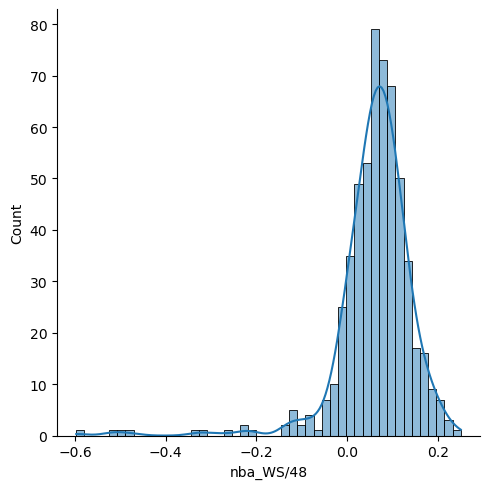

In [36]:
# plot winshare
sns.displot(draft_df, x = 'nba_WS/48', kde=True)

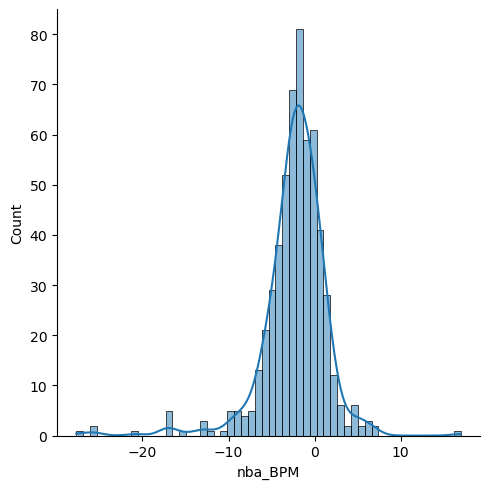

In [37]:
# plot box plus/minus
sns.displot(draft_df, x = 'nba_BPM', kde=True)

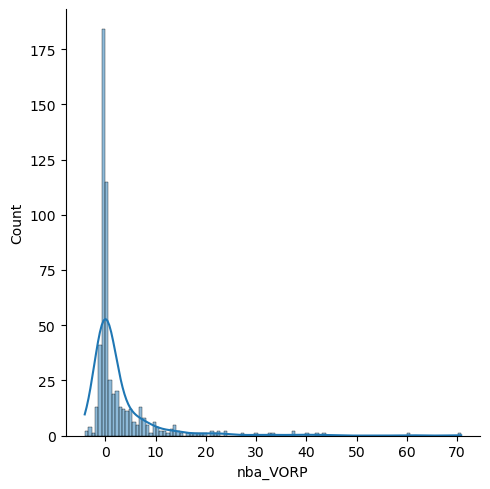

In [38]:
# plot value over replacement player
sns.displot(draft_df, x = 'nba_VORP', kde=True)

### Defining our target class

All of the considered metrics above have a normal distribution (albeit with skew) which is a good indicator for inputs to our target class.

We will attempt to frame the problem as a classification one. This requires us to propose a classification/labelling approach for the definition of a success/performant player. As an initial starting point we will apply the following:

- At least 3 years of play
- Positive WS/48, VORP

Because of the first criteria our data will be limited to up to 2019 draft class (since this is the last class with at least 3 years of play)

BPM is excluded for now as based on eye test (shown in table a few cells below) some players who otherwise would considered to have done well have negative BPM despite positive WS/48 and VORP (ie. Taj Gibson). If the model requires a higher bar for success, tweaks could be made.

We acknowledge also that the WS/48, VORP and BPM may be biased/preferential to classes that have been in the league longer (ie. class of 2009 will have grown into their roles vs class of 2019 may still be benchwarming). Since we are not comparing between players but rather their own performance individually, we believe this is acceptable.

Future work can try to predict these exact values as a regression problem if that is may provide a more nuanced view.

In [39]:
# define how we will classify draft players as successful or not
thresh = {
    'nba_Yrs' : 3, # opinion: not great investment if player does not last
    'nba_WS/48' : 0, # league average
    'nba_BPM' : 0, # league average / not used as similar to VORP (yet contradicts)
    'nba_VORP' : 0 # league average
}
# note there is room for improvements with these thresholds depending on 
# definition of 'success'

In [40]:
#(draft_df['nba_BPM'] >= thresh['nba_BPM']) & \
draft_df.loc[:, ('is_performant')] = \
(draft_df['nba_Yrs'] >= thresh['nba_Yrs']) & \
(draft_df['nba_WS/48'] >= thresh['nba_WS/48']) & \
(draft_df['nba_VORP'] >= thresh['nba_VORP'])

In [41]:
# sanity check the target class split (note this is draft classes 2009 through 2021)
draft_df['is_performant'].value_counts()

is_performant
False    355
True     241
Name: count, dtype: int64

In [42]:
# in reality this is the split if we only consider up to 2019 draft class
draft_df[draft_df['nba_DraftYear']<=2019]['is_performant'].value_counts()

is_performant
False    262
True     241
Name: count, dtype: int64

In [43]:
# show a sample of which players are categorized as performant (or not)
draft_df.loc[:, ('Player', 'nba_Yrs', 'nba_G', 'nba_WS', 'nba_WS/48', 'nba_BPM', 'nba_VORP', 'is_performant')].iloc[0:25]

,Player,nba_Yrs,nba_G,nba_WS,nba_WS/48,nba_BPM,nba_VORP,is_performant
0,Blake Griffin,12.0,716.0,79.2,0.160,3.4,32.5,True
1,Hasheem Thabeet,5.0,224.0,4.8,0.099,-2.7,-0.4,False
2,James Harden,13.0,921.0,146.6,0.221,6.8,70.8,True
3,Tyreke Evans,10.0,594.0,28.4,0.075,0.8,13.1,True
5,Jonny Flynn,3.0,163.0,-1.1,-0.015,-4.0,-1.9,False
6,Stephen Curry,13.0,816.0,119.4,0.204,6.5,60.4,True
7,Jordan Hill,8.0,409.0,16.4,0.102,-2.0,0.0,True
8,DeMar DeRozan,13.0,936.0,82.7,0.124,0.7,22.2,True
10,Terrence Williams,4.0,153.0,-0.2,-0.004,-2.8,-0.6,False
11,Gerald Henderson,8.0,535.0,18.3,0.063,-1.8,0.6,True


In [44]:
# scatter plot of where performant players fall in relation to VORP and WS/48
# sns.scatterplot(data = draft_df, x = 'nba_WS/48', y = 'nba_VORP', hue = 'is_performant')

In [45]:
# spot checking any specific player of interest
draft_df[draft_df['Player'].str.contains('Michael', regex = False)]

,nba_Rk,nba_Pk,nba_Tm,Player,College,nba_Yrs,nba_G,nba_TOTMP,nba_TOTPTS,nba_TOTTRB,nba_TOTAST,nba_FG%,nba_3P%,nba_FT%,nba_WS,nba_WS/48,nba_BPM,nba_VORP,DraftYr,nba_MPG,nba_PPG,nba_RPG,nba_APG,playerurl,nba_DraftYear,player_name,team,conf,GP,Min_per,Ortg,usg,eFG,TS_per,ORB_per,DRB_per,AST_per,TO_per,FTM,FTA,FT_per,twoPM,twoPA,twoP_per,TPM,TPA,TP_per,blk_per,stl_per,ftr,yr,ht,num,porpag,adjoe,pfr,year,pid,type,Rec Rank,ast/tov,rimmade,rimmade+rimmiss,midmade,midmade+midmiss,rimmade/(rimmade+rimmiss),midmade/(midmade+midmiss),dunksmade,dunksmiss+dunksmade,dunksmade/(dunksmade+dunksmiss),pick,drtg,adrtg,dporpag,stops,bpm,obpm,dbpm,gbpm,mp,ogbpm,dgbpm,oreb,dreb,treb,ast,stl,blk,pts,Unnamed: 64,Unnamed: 65,is_performant
181,2,2,CHA,Michael Kidd-Gilchrist,Kentucky,8.0,446.0,10978.0,3750.0,2420.0,515.0,0.474,0.272,0.715,21.0,0.092,-1.8,0.6,2012,24.6,8.4,5.4,1.2,https://www.sports-reference.com/cbb/players/m...,2012,Michael Kidd-Gilchrist,Kentucky,SEC,40.0,77.8,111.8,21.3,51.1,57.05,10.3,16.1,10.8,19.6,143.0,192.0,0.745,147.0,275.0,0.535,13.0,51.0,0.255,2.8,1.9,58.9,Fr,7-Jun,14,3.81007,119.626,3.1,2012.0,22362.0,all,99.6,0.862069,100.0,143.0,47.0,132.0,0.6993,0.3561,34.0,36.0,0.9444,2.0,90.9710,86.5498,4.29842,242.9530,8.18856,5.00434,3.18423,6.73574,31.1250,3.86278,2.87296,2.5750,4.8500,7.4250,1.8750,0.9750,0.9250,11.9000,Wing F,2.44492,True
250,11,11,PHI,Michael Carter-Williams,Syracuse,8.0,391.0,9898.0,4023.0,1713.0,1701.0,0.402,0.255,0.706,6.6,0.032,-1.2,1.9,2013,25.3,10.3,4.4,4.4,https://www.sports-reference.com/cbb/players/m...,2013,Michael Carter-Williams,Syracuse,BE,40.0,87.5,102.6,24.4,43.8,49.13,4.0,11.1,40.2,24.1,129.0,186.0,0.694,120.0,274.0,0.438,35.0,120.0,0.292,1.7,4.8,47.2,So,6-Jun,1,3.78583,115.092,2.6,2013.0,23112.0,all,95.0,2.147059,86.0,146.0,34.0,126.0,0.5890,0.2698,20.0,24.0,0.8333,11.0,86.8313,82.3180,5.29067,299.6620,9.12808,4.84479,4.28329,8.82116,35.2000,3.95766,4.86349,1.2750,3.6000,4.8750,7.3000,2.7750,0.4750,11.8500,Pure PG,5.16731,True
468,49,49,DET,Michael Gbinije,Syracuse,1.0,9.0,32.0,4.0,3.0,2.0,0.100,0.000,1.000,-0.1,-0.136,-12.1,-0.1,2016,3.6,0.4,0.3,0.2,https://www.sports-reference.com/cbb/players/m...,2016,Michael Gbinije,Syracuse,ACC,37.0,93.8,111.2,24.8,55.4,57.36,3.2,8.7,26.5,18.5,106.0,160.0,0.662,134.0,255.0,0.525,91.0,233.0,0.391,1.1,3.1,32.8,Sr,7-Jun,0.0,4.74407,123.404,2.8,2016.0,21893.0,all,94.6,1.523821,98.0,151.0,36.0,105.0,0.6490,0.3429,22.0,26.0,0.8462,49.0,100.6890,94.4563,4.49088,236.4470,6.88167,5.11005,1.77162,7.60032,37.8919,5.00060,2.59972,1.0811,3.0000,4.0811,4.3243,1.9189,0.3514,17.4865,Scoring PG,10.17730,False
553,14,14,DEN,Michael Porter Jr.,Missouri,3.0,125.0,3080.0,1763.0,763.0,133.0,0.518,0.419,0.795,9.6,0.150,2.1,3.1,2018,24.6,14.1,6.1,1.1,https://www.sports-reference.com/cbb/players/m...,2018,Michael Porter Jr.,Missouri,SEC,3.0,4.1,92.7,33.3,38.3,43.76,9.5,32.5,4.6,10.1,7.0,9.0,0.778,7.0,20.0,0.350,3.0,10.0,0.300,2.0,3.4,30.0,Fr,10-Jun,13.0,1.62752,113.997,4.5,2018.0,51186.0,all,99.8,0.333300,7.0,13.0,0.0,7.0,0.5385,0.0000,0.0,0.0,NaN,14.0,88.6588,83.9262,2.79063,14.5523,-4.93399,-3.94221,-0.99178,8.15219,17.6667,4.77390,3.37829,1.3333,5.3333,6.6667,0.3333,1.0000,0.3333,10.0000,Stretch 4,11.25920,True


In [189]:
import plotly.express as px
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [190]:
# interactive scatter plot of where performant players fall in relation to VORP, WS/48, nba_Yrs
fig = px.scatter(data_frame = draft_df,       
           x = 'nba_WS/48', y = 'nba_VORP', 
           color = 'is_performant',
           symbol_sequence= ['circle', 'x'],
           symbol = draft_df['nba_Yrs']>=3,
           labels = {'symbol' : 'nba_Yrs>=3'},
           hover_name = 'Player', 
           hover_data = ['nba_Yrs', 'nba_DraftYear'],
           title = 'Factors leading to NBA player is_performant label'
           )
fig.show()
# more marker choices available at: https://plotly.com/python/marker-style/

This looks like a good start. Note that Zion Williamson falls into the non-performant category as the data only extends to 2022. With only three years into the league during this time, he sat out one year due to injury, which correctly categorizes him based on the point in time data and our criteria.

## Model Preprocessing

[Back to Top](##Introduction)

### Choosing our independent variables

For our independent variables, we will exclude the following columns
- Any NBA career stats (no longer required as we have used them to produce our target)
- Some advanced college stats with missing values (not our primary focus so we will not wrangle with them)
- Data that introduces subjective expert judgment bias (ie. recruitment rank)

In [48]:
# review the columns in our dataset
draft_df.columns.to_list()

['nba_Rk',
 'nba_Pk',
 'nba_Tm',
 'Player',
 'College',
 'nba_Yrs',
 'nba_G',
 'nba_TOTMP',
 'nba_TOTPTS',
 'nba_TOTTRB',
 'nba_TOTAST',
 'nba_FG%',
 'nba_3P%',
 'nba_FT%',
 'nba_WS',
 'nba_WS/48',
 'nba_BPM',
 'nba_VORP',
 'DraftYr',
 'nba_MPG',
 'nba_PPG',
 'nba_RPG',
 'nba_APG',
 'playerurl',
 'nba_DraftYear',
 'player_name',
 'team',
 'conf',
 'GP',
 'Min_per',
 'Ortg',
 'usg',
 'eFG',
 'TS_per',
 'ORB_per',
 'DRB_per',
 'AST_per',
 'TO_per',
 'FTM',
 'FTA',
 'FT_per',
 'twoPM',
 'twoPA',
 'twoP_per',
 'TPM',
 'TPA',
 'TP_per',
 'blk_per',
 'stl_per',
 'ftr',
 'yr',
 'ht',
 'num',
 'porpag',
 'adjoe',
 'pfr',
 'year',
 'pid',
 'type',
 'Rec Rank',
 'ast/tov',
 'rimmade',
 'rimmade+rimmiss',
 'midmade',
 'midmade+midmiss',
 'rimmade/(rimmade+rimmiss)',
 'midmade/(midmade+midmiss)',
 'dunksmade',
 'dunksmiss+dunksmade',
 'dunksmade/(dunksmade+dunksmiss)',
 'pick',
 'drtg',
 'adrtg',
 'dporpag',
 'stops',
 'bpm',
 'obpm',
 'dbpm',
 'gbpm',
 'mp',
 'ogbpm',
 'dgbpm',
 'oreb',
 'dreb',


In [49]:
# mark the final columns we want to keep and in which order
model_columns = [
 'Player',
 'nba_DraftYear',
 'year', # (last) year of college stat
 'yr', # college seniority
 'College',
 'conf',
 'ht',
 'GP',
 'Min_per',
 'Ortg',
 'usg',
 'eFG',
 'TS_per',
 'ORB_per',
 'DRB_per',
 'AST_per',
 'TO_per',
 'FTM',
 'FTA',
 'FT_per',
 'twoPM',
 'twoPA',
 'twoP_per',
 'TPM',
 'TPA',
 'TP_per',
 'blk_per',
 'stl_per',
 'ftr',
 'porpag',
 'adjoe',
 'pfr',
 'drtg',
 'adrtg',
 'dporpag',
 'stops',
 'bpm',
 'obpm',
 'dbpm',
 'gbpm',
 'mp',
 'ogbpm',
 'dgbpm',
 'oreb',
 'dreb',
 'treb',
 'ast',
 'stl',
 'blk',
 'pts',
 'is_performant'
]

In [50]:
# now create a copy of our draft_df with only columns of interest
model_df = draft_df[model_columns]
# subset only draft classes with sufficient runway
model_df = model_df[model_df['nba_DraftYear']<=2019] 
model_df.reset_index(inplace=True, drop=True)
model_df.head()

,Player,nba_DraftYear,year,yr,College,conf,ht,GP,Min_per,Ortg,usg,eFG,TS_per,ORB_per,DRB_per,AST_per,TO_per,FTM,FTA,FT_per,twoPM,twoPA,twoP_per,TPM,TPA,TP_per,blk_per,stl_per,ftr,porpag,adjoe,pfr,drtg,adrtg,dporpag,stops,bpm,obpm,dbpm,gbpm,mp,ogbpm,dgbpm,oreb,dreb,treb,ast,stl,blk,pts,is_performant
0,Blake Griffin,2009,2009.0,So,Oklahoma,B12,10-Jun,35.0,80.6,117.6,31.1,65.7,64.77,14.2,32.2,16.3,18.2,191.0,324.0,0.590,297.0,451.0,0.659,3.0,8.0,0.375,3.6,1.9,70.6,6.39363,139.820,3.1,87.4256,82.5913,5.02664,316.560,11.34010,6.90629,4.433840,12.38440,33.2857,9.59816,2.786220,3.8571,10.5429,14.4000,2.2857,1.1143,1.1714,22.6857,True
1,Hasheem Thabeet,2009,2009.0,Jr,UConn,BE,3-Jul,35.0,75.1,118.7,19.4,64.4,64.84,13.4,21.7,3.0,17.5,131.0,209.0,0.627,172.0,267.0,0.644,0.0,0.0,0.000,11.9,1.2,78.3,4.14637,122.991,3.1,83.8351,78.8458,5.07759,287.554,11.51250,3.53021,7.982330,11.20460,31.6286,5.13615,6.068410,3.6857,7.0286,10.7143,0.4857,0.6286,4.2000,13.5714,False
2,James Harden,2009,2009.0,So,Arizona State,P10,5-Jun,35.0,88.3,112.8,32.6,55.3,60.66,5.5,14.6,29.2,19.0,204.0,270.0,0.756,163.0,289.0,0.564,58.0,163.0,0.356,1.1,3.1,59.7,6.47615,137.102,3.2,95.6385,89.5229,4.50387,234.839,10.37380,7.16968,3.204120,9.81250,35.8286,6.88906,2.923440,1.3714,4.2000,5.5714,4.2286,1.6857,0.3143,20.1143,True
3,Tyreke Evans,2009,2009.0,Fr,Memphis,CUSA,6-Jun,37.0,72.2,101.8,33.0,48.9,52.92,5.0,15.3,30.0,21.8,138.0,194.0,0.711,196.0,381.0,0.514,34.0,124.0,0.274,2.8,4.2,38.4,3.78458,122.038,3.3,82.1427,79.0978,4.72624,250.295,10.03830,3.86939,6.168880,10.57830,28.9730,5.31444,5.263820,1.2703,4.0811,5.3514,3.8649,2.0811,0.7838,17.0811,True
4,Jonny Flynn,2009,2009.0,So,Syracuse,BE,Jun-00,37.0,90.7,111.9,24.9,50.6,56.57,1.9,5.9,32.6,20.5,175.0,223.0,0.785,168.0,325.0,0.517,45.0,140.0,0.321,0.4,2.0,48.0,5.36686,126.920,1.5,103.6020,97.0090,3.68145,214.199,4.75927,5.21382,-0.454556,5.64943,37.4865,5.10228,0.547152,0.5946,2.2162,2.8108,6.7027,1.3514,0.1622,17.4595,False


In [51]:
model_df.shape

(503, 51)

### Correcting data formats
Ht (player height) which should be height data in feet and inches is incorrectly intepretted as a date, which needs correction.


In [52]:
# get examples of all 'heights'
model_df['ht'].value_counts().index

Index(['6-Jun', '5-Jun', '10-Jun', '8-Jun', '9-Jun', '7-Jun', '4-Jun',
       '11-Jun', '3-Jun', '2-Jun', 'Jul-00', '1-Jun', 'Jun-00', '11-May',
       '1-Jul', '9-May', '3-Jul', '10-May', '2-Jul'],
      dtype='object', name='ht')

In [53]:
# laborious but quick and dirty way to clean this column up (only 19 values)
# define the inches equivalent
height_dict = {
'6-Jun' : 78, '5-Jun': 77, '10-Jun': 82, '8-Jun': 80, '9-Jun': 81, '7-Jun': 79, '4-Jun': 76,
       '11-Jun': 83, '3-Jun': 75, '2-Jun': 74, 'Jul-00': 84, '1-Jun': 73, 'Jun-00': 72, '11-May': 71,
       '1-Jul': 85, '9-May': 69, '3-Jul': 87, '10-May': 70, '2-Jul': 86   
}

In [54]:
# we update the column inplace with the correct values
model_df['ht'] = [height_dict[height] for height in model_df['ht']] # update to inches
model_df.head()

,Player,nba_DraftYear,year,yr,College,conf,ht,GP,Min_per,Ortg,usg,eFG,TS_per,ORB_per,DRB_per,AST_per,TO_per,FTM,FTA,FT_per,twoPM,twoPA,twoP_per,TPM,TPA,TP_per,blk_per,stl_per,ftr,porpag,adjoe,pfr,drtg,adrtg,dporpag,stops,bpm,obpm,dbpm,gbpm,mp,ogbpm,dgbpm,oreb,dreb,treb,ast,stl,blk,pts,is_performant
0,Blake Griffin,2009,2009.0,So,Oklahoma,B12,82,35.0,80.6,117.6,31.1,65.7,64.77,14.2,32.2,16.3,18.2,191.0,324.0,0.590,297.0,451.0,0.659,3.0,8.0,0.375,3.6,1.9,70.6,6.39363,139.820,3.1,87.4256,82.5913,5.02664,316.560,11.34010,6.90629,4.433840,12.38440,33.2857,9.59816,2.786220,3.8571,10.5429,14.4000,2.2857,1.1143,1.1714,22.6857,True
1,Hasheem Thabeet,2009,2009.0,Jr,UConn,BE,87,35.0,75.1,118.7,19.4,64.4,64.84,13.4,21.7,3.0,17.5,131.0,209.0,0.627,172.0,267.0,0.644,0.0,0.0,0.000,11.9,1.2,78.3,4.14637,122.991,3.1,83.8351,78.8458,5.07759,287.554,11.51250,3.53021,7.982330,11.20460,31.6286,5.13615,6.068410,3.6857,7.0286,10.7143,0.4857,0.6286,4.2000,13.5714,False
2,James Harden,2009,2009.0,So,Arizona State,P10,77,35.0,88.3,112.8,32.6,55.3,60.66,5.5,14.6,29.2,19.0,204.0,270.0,0.756,163.0,289.0,0.564,58.0,163.0,0.356,1.1,3.1,59.7,6.47615,137.102,3.2,95.6385,89.5229,4.50387,234.839,10.37380,7.16968,3.204120,9.81250,35.8286,6.88906,2.923440,1.3714,4.2000,5.5714,4.2286,1.6857,0.3143,20.1143,True
3,Tyreke Evans,2009,2009.0,Fr,Memphis,CUSA,78,37.0,72.2,101.8,33.0,48.9,52.92,5.0,15.3,30.0,21.8,138.0,194.0,0.711,196.0,381.0,0.514,34.0,124.0,0.274,2.8,4.2,38.4,3.78458,122.038,3.3,82.1427,79.0978,4.72624,250.295,10.03830,3.86939,6.168880,10.57830,28.9730,5.31444,5.263820,1.2703,4.0811,5.3514,3.8649,2.0811,0.7838,17.0811,True
4,Jonny Flynn,2009,2009.0,So,Syracuse,BE,72,37.0,90.7,111.9,24.9,50.6,56.57,1.9,5.9,32.6,20.5,175.0,223.0,0.785,168.0,325.0,0.517,45.0,140.0,0.321,0.4,2.0,48.0,5.36686,126.920,1.5,103.6020,97.0090,3.68145,214.199,4.75927,5.21382,-0.454556,5.64943,37.4865,5.10228,0.547152,0.5946,2.2162,2.8108,6.7027,1.3514,0.1622,17.4595,False


### Setting dtype for categorical variables

In [55]:
# note the following categoricals that require encoding 
# (ignoring Player which will be dropped)
model_df.select_dtypes(include='object').nunique()

Player     501
yr           4
College    129
conf        28
dtype: int64

In [56]:
# update these to type category and verify changes
objects = model_df.select_dtypes(['object']).columns
for o in objects:
    model_df[o] = model_df[o].astype('category')
model_df['year'] = model_df['year'].astype('int64') # cleaning up formatting
model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 503 entries, 0 to 502
Data columns (total 51 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Player         503 non-null    category
 1   nba_DraftYear  503 non-null    int64   
 2   year           503 non-null    int64   
 3   yr             503 non-null    category
 4   College        501 non-null    category
 5   conf           503 non-null    category
 6   ht             503 non-null    int64   
 7   GP             503 non-null    float64 
 8   Min_per        503 non-null    float64 
 9   Ortg           503 non-null    float64 
 10  usg            503 non-null    float64 
 11  eFG            503 non-null    float64 
 12  TS_per         503 non-null    float64 
 13  ORB_per        503 non-null    float64 
 14  DRB_per        503 non-null    float64 
 15  AST_per        503 non-null    float64 
 16  TO_per         503 non-null    float64 
 17  FTM            503 non-null    floa

### Setting X and Y

In [57]:
# set our X and y
X = model_df.drop(columns = ['is_performant', 'Player', 'nba_DraftYear', 'year'])
#X.drop(columns = ['yr', 'College', 'conf'], inplace=True) # per above
y = model_df['is_performant']

In [58]:
# verify
X.head()

,yr,College,conf,ht,GP,Min_per,Ortg,usg,eFG,TS_per,ORB_per,DRB_per,AST_per,TO_per,FTM,FTA,FT_per,twoPM,twoPA,twoP_per,TPM,TPA,TP_per,blk_per,stl_per,ftr,porpag,adjoe,pfr,drtg,adrtg,dporpag,stops,bpm,obpm,dbpm,gbpm,mp,ogbpm,dgbpm,oreb,dreb,treb,ast,stl,blk,pts
0,So,Oklahoma,B12,82,35.0,80.6,117.6,31.1,65.7,64.77,14.2,32.2,16.3,18.2,191.0,324.0,0.590,297.0,451.0,0.659,3.0,8.0,0.375,3.6,1.9,70.6,6.39363,139.820,3.1,87.4256,82.5913,5.02664,316.560,11.34010,6.90629,4.433840,12.38440,33.2857,9.59816,2.786220,3.8571,10.5429,14.4000,2.2857,1.1143,1.1714,22.6857
1,Jr,UConn,BE,87,35.0,75.1,118.7,19.4,64.4,64.84,13.4,21.7,3.0,17.5,131.0,209.0,0.627,172.0,267.0,0.644,0.0,0.0,0.000,11.9,1.2,78.3,4.14637,122.991,3.1,83.8351,78.8458,5.07759,287.554,11.51250,3.53021,7.982330,11.20460,31.6286,5.13615,6.068410,3.6857,7.0286,10.7143,0.4857,0.6286,4.2000,13.5714
2,So,Arizona State,P10,77,35.0,88.3,112.8,32.6,55.3,60.66,5.5,14.6,29.2,19.0,204.0,270.0,0.756,163.0,289.0,0.564,58.0,163.0,0.356,1.1,3.1,59.7,6.47615,137.102,3.2,95.6385,89.5229,4.50387,234.839,10.37380,7.16968,3.204120,9.81250,35.8286,6.88906,2.923440,1.3714,4.2000,5.5714,4.2286,1.6857,0.3143,20.1143
3,Fr,Memphis,CUSA,78,37.0,72.2,101.8,33.0,48.9,52.92,5.0,15.3,30.0,21.8,138.0,194.0,0.711,196.0,381.0,0.514,34.0,124.0,0.274,2.8,4.2,38.4,3.78458,122.038,3.3,82.1427,79.0978,4.72624,250.295,10.03830,3.86939,6.168880,10.57830,28.9730,5.31444,5.263820,1.2703,4.0811,5.3514,3.8649,2.0811,0.7838,17.0811
4,So,Syracuse,BE,72,37.0,90.7,111.9,24.9,50.6,56.57,1.9,5.9,32.6,20.5,175.0,223.0,0.785,168.0,325.0,0.517,45.0,140.0,0.321,0.4,2.0,48.0,5.36686,126.920,1.5,103.6020,97.0090,3.68145,214.199,4.75927,5.21382,-0.454556,5.64943,37.4865,5.10228,0.547152,0.5946,2.2162,2.8108,6.7027,1.3514,0.1622,17.4595


In [59]:
# verify
y[:5]

0     True
1    False
2     True
3     True
4    False
Name: is_performant, dtype: bool

### Engineering our features

With X and Y defined we will perform OneHotEncoding for our categorical variables and StandardScaler for our numerical variables.

We acknowledge there may be correlation in the statistics available, yet we will allow regularization where available to help us reduce the feature count as necessary as opposed to applying any filtering ahead of time.

This approach may be revisited inthe future with SFS or other feature selection methods.

In [60]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer

In [61]:
# define the columns in separate lists based on what needs which encoding
ohe_list = X.select_dtypes(include = 'category').columns
scale_list = X.select_dtypes(exclude = 'category').columns

print(f'One Hot Enode the following: {ohe_list.to_list()}\nStandard Scale the following: {scale_list.to_list()}')
#print(f'Standard Scale the following: {scale_list.to_list()}')

One Hot Enode the following: ['yr', 'College', 'conf']
Standard Scale the following: ['ht', 'GP', 'Min_per', 'Ortg', 'usg', 'eFG', 'TS_per', 'ORB_per', 'DRB_per', 'AST_per', 'TO_per', 'FTM', 'FTA', 'FT_per', 'twoPM', 'twoPA', 'twoP_per', 'TPM', 'TPA', 'TP_per', 'blk_per', 'stl_per', 'ftr', 'porpag', 'adjoe', 'pfr', 'drtg', 'adrtg', 'dporpag', 'stops', 'bpm', 'obpm', 'dbpm', 'gbpm', 'mp', 'ogbpm', 'dgbpm', 'oreb', 'dreb', 'treb', 'ast', 'stl', 'blk', 'pts']


In [62]:
# define our transformer to be used in pipelines later
scaler_ohe_transformer = make_column_transformer(
    (OneHotEncoder(
        drop = 'if_binary', 
        handle_unknown = 'infrequent_if_exist', 
        min_frequency = 0.025), # group to an infrequent category if below
        ohe_list),
    (StandardScaler(),
        scale_list),
    remainder = 'drop',
    verbose_feature_names_out = False   
)

# verify the transformation
df_transform = pd.DataFrame(scaler_ohe_transformer.fit_transform(X), columns=scaler_ohe_transformer.get_feature_names_out())
df_transform.head()

,yr_Fr,yr_Jr,yr_So,yr_Sr,College_Duke,College_Kansas,College_Kentucky,College_Syracuse,College_UCLA,College_UNC,College_infrequent_sklearn,conf_ACC,conf_B10,conf_B12,conf_BE,conf_MWC,conf_P10,conf_P12,conf_SEC,conf_infrequent_sklearn,ht,GP,Min_per,Ortg,usg,eFG,TS_per,ORB_per,DRB_per,AST_per,TO_per,FTM,FTA,FT_per,twoPM,twoPA,twoP_per,TPM,TPA,TP_per,blk_per,stl_per,ftr,porpag,adjoe,pfr,drtg,adrtg,dporpag,stops,bpm,obpm,dbpm,gbpm,mp,ogbpm,dgbpm,oreb,dreb,treb,ast,stl,blk,pts
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.023511,0.296465,0.461700,0.498317,1.486987,2.006363,1.317871,1.714637,2.721868,0.039923,0.395944,1.680606,2.890996,-1.321836,3.076177,2.091842,1.923406,-1.143674,-1.219019,0.422678,0.102229,-0.239033,1.950712,1.592428,1.257091,0.083499,-1.375679,-1.428470,1.583442,2.206978,1.371185,1.054913,0.701160,1.592527,0.497178,1.734424,0.287335,2.136782,3.655832,3.363429,-0.119546,-0.006185,0.335984,1.700810
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.601765,0.296465,0.120379,0.606095,-1.112469,1.783660,1.330783,1.527425,0.927795,-1.364274,0.230627,0.417074,0.977832,-0.977674,0.648114,0.063193,1.705146,-1.235142,-1.315987,-2.113832,2.766375,-1.011174,2.472054,0.030227,-0.041295,0.083499,-1.953584,-2.013610,1.648472,1.630270,1.425600,-0.269977,2.203485,1.222170,0.179949,0.054604,2.310944,1.966922,1.542373,1.858100,-1.171847,-0.914362,3.990303,-0.352317
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.554742,0.296465,0.939550,0.028011,1.820251,0.224746,0.559729,-0.321294,-0.285340,1.401888,0.584878,1.954371,1.992640,0.222242,0.473294,0.305748,0.541094,0.533226,0.659741,0.294161,-0.700224,1.084639,1.212707,1.649793,1.047392,0.178953,-0.053781,-0.345581,0.916203,0.582170,1.066189,1.158276,0.180533,0.785169,0.983981,0.714525,0.371937,-0.326589,-0.158714,-0.242384,1.016297,1.062236,-0.698196,1.121565
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.239091,0.686327,-0.059591,-1.049772,1.909121,-0.871634,-0.868013,-0.438301,-0.165735,1.486351,1.246147,0.564486,0.728289,-0.196334,1.114302,1.320073,-0.186439,-0.198513,0.187021,-0.260489,-0.154556,2.298004,-0.229450,-0.221275,-0.114821,0.274407,-2.225982,-1.974242,1.200026,0.889472,0.960294,-0.136871,1.435724,1.025565,-0.328429,0.121725,1.814881,-0.426781,-0.230219,-0.332237,0.803674,1.801567,-0.131696,0.438293
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-2.132995,0.686327,1.088491,-0.060171,0.109498,-0.580408,-0.194724,-1.163748,-1.771857,1.760855,0.939130,1.343664,1.210739,0.491990,0.570416,0.702658,-0.142787,0.136868,0.380957,0.057420,-0.924911,-0.128727,0.420536,0.878660,0.261834,-1.443766,1.227975,0.823934,-0.133494,0.171797,-0.705944,0.390730,-1.368441,-0.521681,1.301363,0.041853,-1.093145,-1.096411,-1.351749,-1.369879,2.462686,0.437152,-0.881721,0.523533


### Split our data

In [63]:
from sklearn.model_selection import train_test_split

In [64]:
# create train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                   test_size = .2,
                                   #stratify = y,
                                   random_state = 42)

In [65]:
print(f"We have {len(X_train)} training samples and {len(y_test)} hold-out samples")

We have 402 training samples and 101 hold-out samples


## Model Training & Eval Part 1

[Back to Top](##Introduction)

### Approach

**Models:** As a first pass we will conduct a light-weight round of model training.

1. A baseline random classifier model
2. A basic linear regression model
3. A gridsearched linear regression model for best model/hyperparameters
4. Comparing basic linear regression model against KNN, Decision Trees, and SVM

**Metrics:** The metric we will focus on is accuracy (relatively balanced target class) however we will also want to keep recall and precision in check.

**Train/Test:** Note that we have also split our data 80/20 between training and test set, yielding 402 and 101 samples respectively. The test set will serve as our final hold-out set to evaluate our models against unseen data.

- The training set will be further split into training and validation set(s) during hyperparameter tuning via GridSearch (namely with k-fold cross-validation)
- For some models that we build without tuning, we will use the test set directly as our validation set for brevity rather than following strictly a train/validation/test set approach.

In [66]:
# this will hold results for final comparison of model performance on unseen data (ie. test_acc)
# we will not track fit and inference time to keep our comparison focused on accuracy
summary_dict = {
    'model_name': [],
    'train_acc' : [],
    'test_acc' : []
}

### Baseline Random Classifier

In [67]:
# manually transform X_train and X_test in the absence of our pipeline at this point
X_train_t = pd.DataFrame(scaler_ohe_transformer.fit_transform(X_train), columns=scaler_ohe_transformer.get_feature_names_out())
X_test_t = pd.DataFrame(scaler_ohe_transformer.transform(X_test), columns=scaler_ohe_transformer.get_feature_names_out())

In [68]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, precision_recall_curve, roc_curve, f1_score, roc_auc_score, classification_report

In [69]:
# random
clf = DummyClassifier(strategy = 'uniform', random_state = 42
                       ).fit(X_train, y_train)
train_score = clf.score(X_train, y_train)
test_score = clf.score(X_test, y_test)
print(f'Accuracy\nTrain score: {train_score}\nTest score: {test_score}\n')
# create predictions for additional scoring
y_train_pred = clf.predict(X_train_t)
y_test_pred = clf.predict(X_test_t)

# ROC AUC scores
train_score = roc_auc_score(y_train, y_train_pred)
test_score = roc_auc_score(y_test, y_test_pred)
print(f'ROC AUC\nTrain score: {train_score:.2f}\nTest score: {test_score:.2f}\n')

# Classification report
print(f'Classification report')
print(classification_report(y_test, y_test_pred, zero_division=0))

Accuracy
Train score: 0.5024875621890548
Test score: 0.44554455445544555

ROC AUC
Train score: 0.50
Test score: 0.45

Classification report
              precision    recall  f1-score   support

       False       0.51      0.40      0.45        57
        True       0.39      0.50      0.44        44

    accuracy                           0.45       101
   macro avg       0.45      0.45      0.45       101
weighted avg       0.46      0.45      0.45       101



In [70]:
# add model to our results
summary_dict['model_name'].append('Dummy Classifier')
summary_dict['train_acc'].append(train_score)
summary_dict['test_acc'].append(test_score)

### Basic Logistic Regression

In [71]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [72]:
# train our model
lr = LogisticRegression(max_iter=1000).fit(X_train_t, y_train)

In [73]:
# Accuracy
train_score = lr.score(X_train_t, y_train)
test_score = lr.score(X_test_t, y_test)
print(f'Accuracy\nTrain score: {train_score:.2f}\nTest score: {test_score:.2f}\n')
# create predictions for additional scoring
y_train_pred = lr.predict(X_train_t)
y_test_pred = lr.predict(X_test_t)

# ROC AUC scores
train_score = roc_auc_score(y_train, y_train_pred)
test_score = roc_auc_score(y_test, y_test_pred)
print(f'ROC AUC\nTrain score: {train_score:.2f}\nTest score: {test_score:.2f}\n')

# Classification report
print(f'Classification report')
print(classification_report(y_test, y_test_pred, zero_division=0))

Accuracy
Train score: 0.71
Test score: 0.66

ROC AUC
Train score: 0.71
Test score: 0.65

Classification report
              precision    recall  f1-score   support

       False       0.68      0.75      0.72        57
        True       0.63      0.55      0.59        44

    accuracy                           0.66       101
   macro avg       0.66      0.65      0.65       101
weighted avg       0.66      0.66      0.66       101



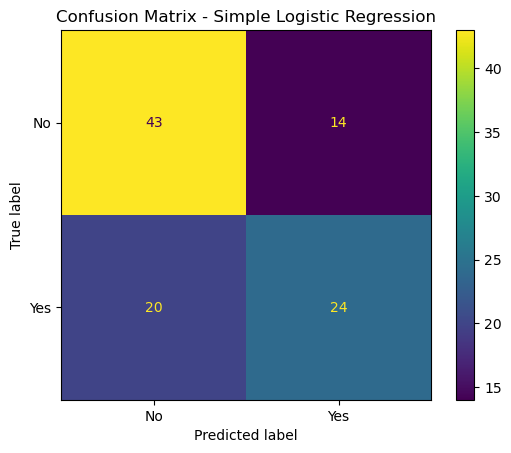

In [74]:
# confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, display_labels=['No', 'Yes'])
plt.title('Confusion Matrix - Simple Logistic Regression')
plt.grid(False)
# disp.plot()

In [75]:
# examinining the features positively related
feature_names = X_train_t.columns
coefs = lr.coef_[0]
coefs_df = pd.DataFrame({'feature': feature_names, 'coef': coefs}, columns = ['feature', 'coef'])
coefs_df.sort_values(by = 'coef', ascending = False).head().T

,50,48,44,49,17
feature,stops,adrtg,porpag,dporpag,conf_P10
coef,1.130493,1.026243,0.962225,0.666987,0.554836


In [76]:
# examinining the features negatively related
coefs_df.sort_values(by = 'coef', ascending = False).tail().T

,3,55,22,8,64
feature,yr_Sr,mp,GP,College_Syracuse,pts
coef,-0.6596,-0.664254,-0.680459,-0.712054,-0.891222


In [77]:
# add model to our results
summary_dict['model_name'].append('Logistic Regression (Basic)')
summary_dict['train_acc'].append(train_score)
summary_dict['test_acc'].append(test_score)

### Logistic Regression: Simple Pipeline and Gridsearch

In [78]:
from sklearn.pipeline import Pipeline

In [79]:
lr_pipe = Pipeline([
    ('transformer', scaler_ohe_transformer),
    ('model', LogisticRegression())
])

In [80]:
from sklearn.model_selection import GridSearchCV

In [81]:
params = {
    'model__C': [0.0001, 0.001, 0.1, 1.0, 10.0, 100.0],
    'model__penalty': ['l1','l2'],
    'model__solver': ['liblinear'],
    'model__max_iter': [1000, 2000, 4000]
}

In [82]:
lr_grid = GridSearchCV(
            estimator = lr_pipe,
            param_grid = params,
            scoring = 'accuracy',
            cv = 3,
            #error_score = 'raise',
            #min_resources = 10000,
            n_jobs = -1, # instead of -1, to supress warnings
            verbose = 1
    ).fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


In [83]:
pd.DataFrame(lr_grid.cv_results_).nsmallest(5, columns = 'rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__C,param_model__max_iter,param_model__penalty,param_model__solver,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
13,0.025164,0.002521,0.013178,0.002089,0.1,1000,l2,liblinear,"{'model__C': 0.1, 'model__max_iter': 1000, 'mo...",0.597015,0.694030,0.619403,0.636816,0.041476,1
15,0.021747,0.000580,0.009038,0.000481,0.1,2000,l2,liblinear,"{'model__C': 0.1, 'model__max_iter': 2000, 'mo...",0.597015,0.694030,0.619403,0.636816,0.041476,1
17,0.022142,0.002037,0.009073,0.000111,0.1,4000,l2,liblinear,"{'model__C': 0.1, 'model__max_iter': 4000, 'mo...",0.597015,0.694030,0.619403,0.636816,0.041476,1
19,0.019840,0.000103,0.006760,0.000300,1.0,1000,l2,liblinear,"{'model__C': 1.0, 'model__max_iter': 1000, 'mo...",0.604478,0.671642,0.626866,0.634328,0.027923,4
21,0.025210,0.006159,0.008670,0.000136,1.0,2000,l2,liblinear,"{'model__C': 1.0, 'model__max_iter': 2000, 'mo...",0.604478,0.671642,0.626866,0.634328,0.027923,4


In [84]:
# add model to our results
summary_dict['model_name'].append('Logistic Regression (Grid)')
summary_dict['train_acc'].append(lr_grid.best_estimator_.score(X_train, y_train))
summary_dict['test_acc'].append(lr_grid.best_estimator_.score(X_test, y_test))

### Other Default Model Comparisons: KNN, DecisionTree, SVM

In [85]:
# build dictionary to hold results
results = {
    'Model' : [],
    'Accuracy' : [],
    'Precision' : [],
    'Recall' : [],
    'F1-Score' : [],
    'ROC AUC' : [],
    'AP Score' : [],
    'Train Time' : [],
    'Inference Time' : []
}

In [86]:
# add intel patch to improve SVC performance
from sklearnex import patch_sklearn
patch_sklearn('SVC')

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [87]:
# import our models of interest
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [88]:
# define our models (and params)
models = {
    'KNN' : KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Logistic Regression': LogisticRegression(),
    'SVM': SVC()
}

In [89]:
import time
from sklearn import metrics

In [90]:
# fit and predict our models and track time to train and infer
for model_name, model in models.items():
  start_time = time.time()
  model.fit(X_train_t, y_train)
  train_time = time.time() - start_time

  start_time = time.time()
  y_pred = model.predict(X_test_t)
  inference_time = time.time() - start_time

  accuracy = metrics.accuracy_score(y_test, y_pred)
  precision = metrics.precision_score(y_test, y_pred)
  recall = metrics.recall_score(y_test, y_pred)
  f1 = metrics.f1_score(y_test, y_pred)

  if model_name in ['KNN', 'Decision Tree', 'Logistic Regression']:
    y_score = model.predict_proba(X_test_t)[:,1]
  else:
    y_score = model.decision_function(X_test_t)
  
  rocauc = metrics.roc_auc_score(y_test, y_score)
  ap = metrics.average_precision_score(y_test, y_score)

  results['Model'].append(model_name)
  results['Accuracy'].append(accuracy)
  results['Precision'].append(precision)
  results['Recall'].append(recall)
  results['F1-Score'].append(f1)
  results['ROC AUC'].append(rocauc)
  results['AP Score'].append(ap)
  results['Train Time'].append(train_time)
  results['Inference Time'].append(inference_time)

In [91]:
pd.DataFrame(results)

,Model,Accuracy,Precision,Recall,F1-Score,ROC AUC,AP Score,Train Time,Inference Time
0,KNN,0.574257,0.510638,0.545455,0.527473,0.567384,0.513334,0.002503,0.067372
1,Decision Tree,0.653465,0.588235,0.681818,0.631579,0.656699,0.539683,0.018927,0.001501
2,Logistic Regression,0.663366,0.631579,0.545455,0.585366,0.734848,0.660147,0.016876,0.001343
3,SVM,0.683168,0.630435,0.659091,0.644444,0.731659,0.639816,0.009878,0.001924


In [92]:
# add only SVM model to our results (better logistic regression models already previously logged)
summary_dict['model_name'].append('SVM')
summary_dict['train_acc'].append(models['SVM'].score(X_train_t, y_train))
summary_dict['test_acc'].append(models['SVM'].score(X_test_t, y_test))

In [93]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

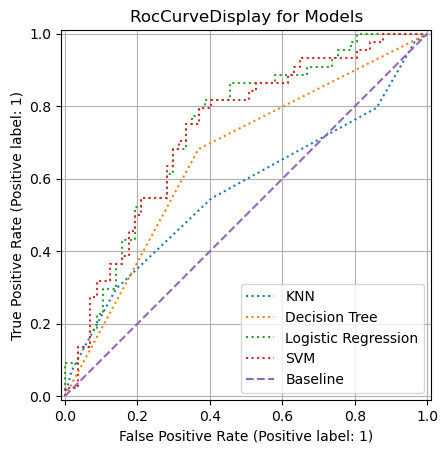

In [94]:
# plot the AUC ROC curve
fig, ax = plt.subplots()
for model_name, model in models.items():
        RocCurveDisplay.from_estimator(model, 
                X_test_t, y_test, pos_label = 1, ax = ax, label = model_name,
                linestyle = ':')
plt.grid(True)
plt.plot(np.arange(0, 1.1, .1), np.arange(0, 1.1, .1), label = 'Baseline',
         linestyle = '--');
plt.title(f'RocCurveDisplay for Models')
plt.legend();

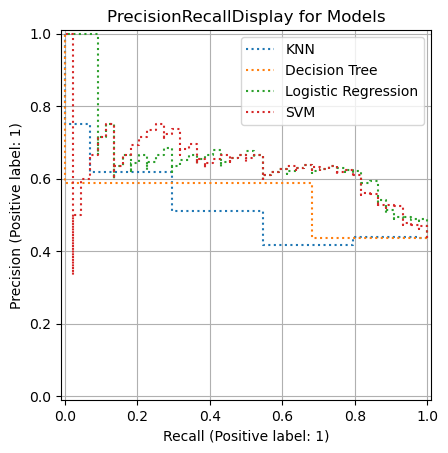

In [95]:
# plot the PR curve
fig, ax = plt.subplots()
for model_name, model in models.items():
        PrecisionRecallDisplay.from_estimator(model, 
                X_test_t, y_test, pos_label = 1, ax = ax, label = model_name,
                linestyle = ':')
plt.grid(True)
plt.title(f'PrecisionRecallDisplay for Models')
plt.legend();

## Model Training & Eval Part 2

[Back to Top](##Introduction)

Having some models their reference scores for comparison, we push forward to evaluate additional techniques that may yield better performance. Namely we will explore:

- SVM with GridSearch
- Ensemble Techniques (RandomForest and AdaBoost)
- Neural Network (Sequential Model with KerasClassifer wrapper)

### SVM GridSearch

In [96]:
svc_params = {
    'model__C': [0.0001, 0.001, 0.1, 1.0, 10.0, 100.0],
    'model__kernel': ['poly', 'rbf', 'sigmoid'],
}

In [97]:
svc_pipe = Pipeline([
    ('transformer', scaler_ohe_transformer),
    ('model', SVC())
])

In [98]:
svc_grid = GridSearchCV(
            estimator = svc_pipe,
            param_grid = svc_params,
            scoring = 'accuracy',
            cv = 3,
            #error_score = 'raise',
            #min_resources = 10000,
            n_jobs = -1, # instead of -1, to supress warnings
            verbose = 1
    ).fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


In [99]:
pd.DataFrame(svc_grid.cv_results_).nsmallest(5, columns = 'rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__C,param_model__kernel,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
8,0.032662,0.000268,0.010466,0.000641,0.1,sigmoid,"{'model__C': 0.1, 'model__kernel': 'sigmoid'}",0.574627,0.641791,0.619403,0.611940,0.027923,1
10,0.025074,0.000954,0.010653,0.000455,1.0,rbf,"{'model__C': 1.0, 'model__kernel': 'rbf'}",0.544776,0.641791,0.626866,0.604478,0.042653,2
11,0.029228,0.001622,0.011233,0.000065,1.0,sigmoid,"{'model__C': 1.0, 'model__kernel': 'sigmoid'}",0.559701,0.649254,0.589552,0.599502,0.037230,3
9,0.026145,0.001013,0.009703,0.000446,1.0,poly,"{'model__C': 1.0, 'model__kernel': 'poly'}",0.544776,0.597015,0.589552,0.577114,0.023069,4
7,0.029192,0.003197,0.010572,0.000417,0.1,rbf,"{'model__C': 0.1, 'model__kernel': 'rbf'}",0.567164,0.544776,0.574627,0.562189,0.012684,5


In [100]:
# add model to our results
summary_dict['model_name'].append('SVM (Grid)')
summary_dict['train_acc'].append(svc_grid.best_estimator_.score(X_train, y_train))
summary_dict['test_acc'].append(svc_grid.best_estimator_.score(X_test, y_test))

### Ensemble Part 1 - Bagging: RandomForest

In interest of iterating rapidly, we first build a basic RandomForest with default settings and leverage the out-of-bag feature to provide a generalization score.

In [101]:
from sklearn.ensemble import RandomForestClassifier

In [102]:
forest_pipe = Pipeline([
    ('transformer', scaler_ohe_transformer),
    ('forest_clf', RandomForestClassifier(random_state=42, oob_score=True))
])

forest_pipe = forest_pipe.fit(X_train,y_train)
forest_score = forest_pipe.named_steps['forest_clf'].oob_score_
print(f'Basic RandomForest Accuracy (oob): {forest_score}')

Basic RandomForest Accuracy (oob): 0.6044776119402985


With this reference point, we will further GridSearch the depth and number of trees to seek further improvements.

In [103]:
forest_pipe2 = Pipeline([
    ('transformer', scaler_ohe_transformer),
    ('forest_clf', RandomForestClassifier(random_state=42))
])

In [104]:
forest_params = {
    #'forest_clf__criterion': ['gini', 'entropy', 'log_loss'],
    'forest_clf__n_estimators': [1, 10, 100, 500, 1000, 2000], # n_trees
    'forest_clf__max_depth': [1, 2, 3, 4, 5, None], # depths
    'forest_clf__max_features': [1, 5, 10, 20, None] # forest diversity
}

In [105]:
forest_grid = GridSearchCV(
            estimator = forest_pipe2,
            param_grid = forest_params,
            scoring = 'accuracy',
            cv = 3,
            #error_score = 'raise',
            #min_resources = 10000,
            n_jobs = -1, # instead of -1, to supress warnings
            verbose = 1
    ).fit(X_train, y_train)

Fitting 3 folds for each of 180 candidates, totalling 540 fits


In [106]:
pd.DataFrame(forest_grid.cv_results_).nsmallest(5, columns = 'rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_forest_clf__max_depth,param_forest_clf__max_features,param_forest_clf__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
149,18.753324,0.100843,0.176909,0.019005,5,None,2000,"{'forest_clf__max_depth': 5, 'forest_clf__max_...",0.567164,0.679104,0.656716,0.634328,0.048364,1
64,2.317752,0.001204,0.092194,0.001084,3,1,1000,"{'forest_clf__max_depth': 3, 'forest_clf__max_...",0.604478,0.641791,0.649254,0.631841,0.019587,2
79,0.049401,0.002569,0.010617,0.001324,3,20,10,"{'forest_clf__max_depth': 3, 'forest_clf__max_...",0.574627,0.671642,0.649254,0.631841,0.041476,2
118,7.882203,0.042935,0.094541,0.002100,4,None,1000,"{'forest_clf__max_depth': 4, 'forest_clf__max_...",0.582090,0.664179,0.649254,0.631841,0.035703,2
122,0.260839,0.001435,0.019176,0.000657,5,1,100,"{'forest_clf__max_depth': 5, 'forest_clf__max_...",0.619403,0.634328,0.641791,0.631841,0.009308,2


In [107]:
# add model to our results
summary_dict['model_name'].append('RandomForest (Grid)')
summary_dict['train_acc'].append(forest_grid.best_estimator_.score(X_train, y_train))
summary_dict['test_acc'].append(forest_grid.best_estimator_.score(X_test, y_test))

### Ensemble Part 2 - Boosting: AdaBoost with Decision Stumps

As an alternative, we try boosting to improve performance of weak individual models. In the case below, we try gradient boosting via an ensemble of decision stumps.

In [108]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [109]:
ada_params = {
    'ada_clf__n_estimators' : [1, 10, 100, 500, 1000, 2000],
    'ada_clf__estimator__max_depth' : [1, 2, 3]
}

In [110]:
ada_pipe = Pipeline([
    ('transformer', scaler_ohe_transformer),
    ('ada_clf', AdaBoostClassifier(
                    estimator = DecisionTreeClassifier(),
                    random_state = 42))
])

ada_grid = GridSearchCV(
    estimator = ada_pipe,
    param_grid = ada_params,
    cv = 3,
    scoring = 'accuracy',
    verbose = 1
).fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


In [111]:
pd.DataFrame(ada_grid.cv_results_).nsmallest(5, columns = 'rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ada_clf__estimator__max_depth,param_ada_clf__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
12,0.011255,0.000600,0.003720,0.000098,3,1,"{'ada_clf__estimator__max_depth': 3, 'ada_clf_...",0.582090,0.582090,0.679104,0.614428,0.045733,1
16,4.256269,0.028869,0.160255,0.001322,3,1000,"{'ada_clf__estimator__max_depth': 3, 'ada_clf_...",0.597015,0.604478,0.626866,0.609453,0.012684,2
0,0.010518,0.000559,0.003926,0.000119,1,1,"{'ada_clf__estimator__max_depth': 1, 'ada_clf_...",0.574627,0.611940,0.582090,0.589552,0.016121,3
15,2.118519,0.041080,0.080639,0.000335,3,500,"{'ada_clf__estimator__max_depth': 3, 'ada_clf_...",0.574627,0.589552,0.604478,0.589552,0.012187,3
17,8.467020,0.028902,0.326681,0.010257,3,2000,"{'ada_clf__estimator__max_depth': 3, 'ada_clf_...",0.567164,0.582090,0.611940,0.587065,0.018615,5


In [112]:
# add model to our results
summary_dict['model_name'].append('AdaBoost (Grid)')
summary_dict['train_acc'].append(ada_grid.best_estimator_.score(X_train, y_train))
summary_dict['test_acc'].append(ada_grid.best_estimator_.score(X_test, y_test))

### Neural Networks

In [113]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

2024-05-21 00:48:45.785266: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [114]:
y.value_counts(normalize=True) # currently boolean

is_performant
False    0.520875
True     0.479125
Name: proportion, dtype: float64

In [115]:
# transform feature data to required input format for neural network models
X_train_num = scaler_ohe_transformer.fit_transform(X_train)#.toarray()
X_test_num = scaler_ohe_transformer.transform(X_test)#.toarray() # note transform (not fit transform) - consistent with train model

y_train_num = np.where(y_train, 1, 0)
y_test_num = np.where(y_test, 1, 0)

We will consider the following architecture factors to variate after we try the initial setup below:
- Nodes
- Regularization
- Early Stopping


In [116]:
# for repeatability
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)

nn_model = Sequential()
nn_model.add(Dense(50, activation = 'relu'))#, kernel_regularizer = 'l1'))
nn_model.add(Dropout(0.25))
nn_model.add(Dense(1, activation = 'sigmoid'))
nn_model.compile(optimizer = 'rmsprop', loss = 'bce', metrics = ['acc'])
history = nn_model.fit(X_train_num, y_train_num, validation_data=(X_test_num, y_test_num),
          epochs = 100, verbose = 0,
          #callbacks = EarlyStopping(patience = 4, monitor = 'val_acc'))
          callbacks = EarlyStopping(
               patience = 4, monitor = 'val_loss', start_from_epoch = 25,
               restore_best_weights = True, verbose = 1) 
          )
print(history.history['val_acc'][-1])

Restoring model weights from the end of the best epoch: 27.
Epoch 31: early stopping
0.6237623691558838


In [182]:
fig = px.line(data_frame=history.history, 
        y = ['val_acc','acc'], x =  range(1, len(history.history['loss'])+1),
        labels = {'x': 'epochs', 'value': 'accuracy'},
        line_dash= 'variable'
        )
fig.show()

In [183]:
fig = px.line(data_frame=history.history, 
        y = ['val_loss','loss'], x =  range(1, len(history.history['loss'])+1),
        labels = {'x': 'epochs', 'value': 'loss'},
        line_dash= 'variable'
        )
fig.show()

In [119]:
# add model to our results
summary_dict['model_name'].append('KerasClassifier')
summary_dict['train_acc'].append(history.history['acc'][-4])
summary_dict['test_acc'].append(history.history['val_acc'][-4])

Best model from here so far provides 62% validation/hold-out accuracy. 

- However, this won't be directly comparable with our previous GridSearch results as this used our test/hold-out set.
- We will proceed below with GridSearch for both comparability and testing for best parameters.

### Neural Networks - GridSearch with Wrapper

In [120]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'  # for disabling "TensorFlow binary is optimized..." message 

In [121]:
def build_function(neurons = 1, regularizer = None, dropout = None):
    model = Sequential()
    model.add(Dense(neurons, activation = 'relu', kernel_regularizer = regularizer))
    if dropout != None:  # dropout layer if specified
        model.add(Dropout(dropout))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer = 'rmsprop', loss = 'bce', metrics = ['accuracy'])
    return model

In [122]:
kc_model = KerasClassifier(
            build_fn=build_function, 
            epochs = 100, 
            verbose = 0,
            callbacks = EarlyStopping( # note this normally goes in fit function of model
                patience = 4, monitor = 'val_loss', start_from_epoch = 25,
                restore_best_weights = True, verbose = 0) 
            )

In [123]:
kc_params = {
    'neurons' : [10, 50, 100],
    'regularizer' : ['l1', 'l2', 'l1_l2', None],
    'dropout' : [0.1, 0.2, 0.4, 0.8, None]
}

In [124]:
tf.random.set_seed(42)
kc_grid = GridSearchCV(kc_model, 
                       param_grid = kc_params, cv = 3, n_jobs = 2, 
                       verbose = 1
                       ).fit(X_train_num, y_train_num,
                       validation_split = 0.2 # to avoid providing our hold-out set as validation
                                              # we split a fixed validation set to be used to validate
                                              # across all k-fold cross validation sets (since validation sets
                                              # in GridSearchCV and Keras history/callbacks are not compatibile) 
                       #validation_data=(X_test_num, y_test_num) # this helps provide the history view
                                                                # and not to be confused with what is used in CV
                       )

Fitting 3 folds for each of 60 candidates, totalling 180 fits


In [125]:
pd.DataFrame(kc_grid.cv_results_).nsmallest(5, columns = 'rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dropout,param_neurons,param_regularizer,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
18,2.970688,0.090556,0.054171,0.000879,0.2,50,l1_l2,"{'dropout': 0.2, 'neurons': 50, 'regularizer':...",0.597015,0.679105,0.619403,0.631841,0.034648,1
16,3.451871,0.431933,0.056008,0.000274,0.2,50,l1,"{'dropout': 0.2, 'neurons': 50, 'regularizer':...",0.597015,0.634328,0.656716,0.629353,0.024626,2
22,2.556703,0.269268,0.052103,0.000214,0.2,100,l1_l2,"{'dropout': 0.2, 'neurons': 100, 'regularizer'...",0.604478,0.656716,0.611940,0.624378,0.023069,3
32,3.075792,0.109893,0.059172,0.006551,0.4,100,l1,"{'dropout': 0.4, 'neurons': 100, 'regularizer'...",0.597015,0.656716,0.619403,0.624378,0.024626,3
4,3.366563,0.434184,0.055143,0.000982,0.1,50,l1,"{'dropout': 0.1, 'neurons': 50, 'regularizer':...",0.582090,0.649254,0.634328,0.621891,0.028796,5


In [184]:
fig = px.line(data_frame=kc_grid.best_estimator_.model.history.history, 
        y = ['val_accuracy','accuracy'], x =  range(1, len(kc_grid.best_estimator_.model.history.history['loss'])+1),
        labels = {'x': 'epochs', 'value': 'accuracy'},
        line_dash= 'variable'
        )
fig.show()

KeyError: 'loss'

In [185]:
fig = px.line(data_frame=kc_grid.best_estimator_.model.history.history, 
        y = ['val_loss','loss'], x =  range(1, len(kc_grid.best_estimator_.model.history.history['loss'])+1),
        labels = {'x': 'epochs', 'value': 'loss'},
        line_dash= 'variable'
        )
fig.show()

KeyError: 'loss'

Note:

Each GridSearch cross-validation set is a model on its own. So for CV = 3, each param combination we search and fit creates three models where it:
- uses the training set provided in `.fit()` to create different splits of training and validation sets (of the same input set) for each model, and 
- uses the same test set provided in `validation_data` to to create the history results (ie. val_loss, val_acc). 
If we don't want to use our test (hold-out) set for computing the validation history, we may want to try using the built-in `validation_split`, which *should* then also use a subset of the train set to validate as well.
- documentation is thin on how, if at all, validation sets in each k-fold are actually used towards calculating the val_loss and val_acc for KerasClassifier. Hence, we provide one of the two validation data params above to be sure. However this leads to the same validation set being used across all folds.

Also, `restore_best_weights` argument provides option to restore the best weights if set to True. Default is False and returns the last step.

In [129]:
# add model to our results
summary_dict['model_name'].append('KerasClassifier (Grid)')
summary_dict['train_acc'].append(kc_grid.best_estimator_.score(X_train_num, y_train_num))
summary_dict['test_acc'].append(kc_grid.best_estimator_.score(X_test_num, y_test_num))

## Model Results Summary

[Back to Top](##Introduction)

In [133]:
summary_df = pd.DataFrame(summary_dict)
summary_df

,model_name,train_acc,test_acc
0,Dummy Classifier,0.502588,0.451754
1,Logistic Regression (Basic),0.705757,0.649920
2,Logistic Regression (Grid),0.694030,0.702970
3,SVM,0.786070,0.683168
4,SVM (Grid),0.646766,0.613861
5,RandomForest (Grid),0.907960,0.702970
6,AdaBoost (Grid),0.686567,0.643564
7,KerasClassifier,0.751244,0.623762
8,KerasClassifier (Grid),0.639304,0.702970


In [186]:
fig = px.bar(summary_df, y = 'model_name', x = ['train_acc','test_acc'], 
        barmode = 'group', labels = {'value':'accuracy'}, range_x = [.4, 1])
fig.show()

From the models explored, we have several potential candidates to move forward with at this stage. Note they are all from the best estimators after hyperparameter tuning, providing 70%+ accuracy on our test data set:

- KerasClassifier (Grid)
- RandomForest (Grid)
- Logistic Regression (Grid)

To break the tie, we will proceed with our Logistic Regression model as it is the least computationally expensive and relatively easy to interpret. 

## Model Interpretation

[Back to Top](##Introduction)

### Permutation Importance

While we can examine the model weights for each feature directly for a model such as Logistic Regression, a more model-agnostic approach is to use Permutation Importance. In short, this approach tests the model against various permutations of feature inputs such that it can be understood which features contribute most to the model (ie. would the model performane degrade in the feature's absence).

Note that per [scikit-learn documentation](https://scikit-learn.org/stable/modules/permutation_importance.html) for results from Permutation Importance:

- Features that are deemed of low importance for a bad model (low cross-validation score) could be very important for a good model.
- Permutation importance does not reflect to the intrinsic predictive value of a feature by itself but how important this feature is for a particular model.

In [140]:
from sklearn.inspection import permutation_importance
import seaborn as sns

In [141]:
def plot_permutation_imp(model, X, y):
    # calculate the importance (default uses estimator's default scorer)
    r = permutation_importance(model, X, y,
                            scoring = 'accuracy', # to be explicit scoring to be used
                            n_repeats=30,
                            random_state=42)
    # format the output into a dataframe ordered by importance
    features = model.feature_names_in_
    r_df = pd.DataFrame(features, columns=['features']) #.set_index('features')
    r_df['importances_mean'] = r.importances_mean
    r_df['importances_std'] = r.importances_std
    r_df['importances_std'] = '+/- ' + r_df['importances_std'].round(3).astype(str)
    ordered = r_df.round(3).sort_values(by = 'importances_mean', ascending=False)
    # plot the results as a barplot
    # useful reference for adjusting figure size for figure level vs axes level seaborn plots
    # https://stackoverflow.com/a/70058338
    fig, ax = plt.subplots(figsize=(6, 10)) #dpi=100)
    sns.barplot(ordered, x = 'importances_mean', y = 'features', palette="rocket", ax=ax)
    ax.set(xlabel='Decrease in Accuracy Score', ylabel='Features', title='Permutation Importances (Test Set)')
    sns.despine(bottom=False)

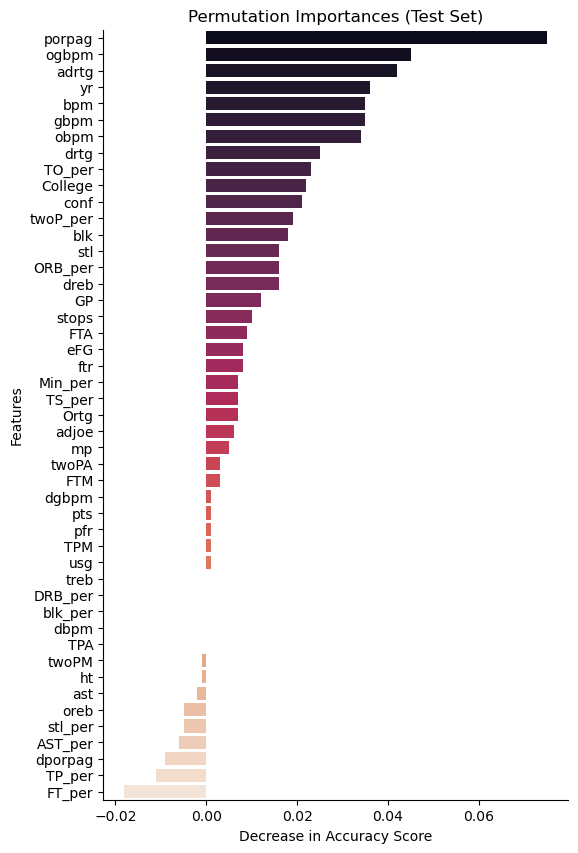

In [142]:
# inspect our best logistic regression model
plot_permutation_imp(lr_grid.best_estimator_, X_test, y_test)

Based on permutation importance (ie. notable decreases in accuracy score when a feature is permuted), we can see the most important features are: 
- `porpag`: Points over replacement per adjusted game
- `ogbpm`: Offensive gbpm
- `adrtg`: Adjusted defensive rating
- `yr`: Year of college
- `bpm`: Box plus/minus
- `gbpm`: gbpm
- `obpm`: Offensive box plus/minus

These observations are reasonable. Given by design these advanced statistics (not including year of college) are made to measure performance relative to other players (as opposed to cut and dry traditional box score statistics), this should naturally extend its usefulness in assessing college players for their NBA performance potential. (Last played) Year of college is notable given there is some intuition that a player who is entering the league at a younger age must be talented/confident for doing so, along with the notion that youth is related to adaptibility.

Lastly, it is notable that a number of other features are also relevant in contributing to the model's predictive performance, albeit to a lesser degree. These include:

- `TO_per`: Turnover %
- `College`: College team
- `conf`: Conference
- `twoP_per`: 2-point %

## Model Predictions

[Back to Top](##Introduction)

In [145]:
def model_predictions(model, X, index):
    """
    Provided model, X test data, and indicies of test data, return the subset of the model_df dataframe with the predicted results.
    Expected columns in the returned dataframe include: 
        player names and features
        y_labels
        y_proba
        y_prediction
    X and y need to be in the format expected of the model/estimator provided
    """
    test_index = index
    model_test_results = model_df.iloc[test_index, :].copy()
    y_proba = model.predict_proba(X)
    y_pred =  model.predict(X)
    model_test_results['prediction_proba'] = y_proba[:,1] # all rows, second column contains probability of class 1
    model_test_results['prediction'] = y_pred
    model_test_results['correct'] = model_test_results['prediction'] == model_test_results['is_performant'] 
    return model_test_results

In [146]:
# predict on our test set with our best model
prediction_df = model_predictions(lr_grid.best_estimator_, X_test, y_test.index) # logistic regression
prediction_df.head()
#model_predictions(kc_grid.best_estimator_, X_test_num, y_test.index) # neural network

,Player,nba_DraftYear,year,yr,College,conf,ht,GP,Min_per,Ortg,usg,eFG,TS_per,ORB_per,DRB_per,AST_per,TO_per,FTM,FTA,FT_per,twoPM,twoPA,twoP_per,TPM,TPA,TP_per,blk_per,stl_per,ftr,porpag,adjoe,pfr,drtg,adrtg,dporpag,stops,bpm,obpm,dbpm,gbpm,mp,ogbpm,dgbpm,oreb,dreb,treb,ast,stl,blk,pts,is_performant,prediction_proba,prediction,correct
268,Jordan Clarkson,2014,2014,Jr,Missouri,SEC,77,35.0,86.8,109.7,27.3,48.1,54.58,2.9,9.3,23.3,16.8,162.0,195.0,0.831,177.0,354.0,0.500,32.0,114.0,0.281,0.6,1.9,41.7,4.52479,125.247,2.5,106.7820,103.0880,3.20357,194.678,3.343170,3.73257,-0.389393,3.62059,35.0857,3.71877,-0.098181,0.8000,3.0286,3.8286,3.3714,1.0857,0.1714,17.4857,True,0.322728,False,False
73,Lazar Hayward,2010,2010,Sr,Marquette,BE,78,34.0,79.5,108.1,29.6,49.5,53.63,8.2,21.3,11.2,12.9,107.0,127.0,0.843,157.0,328.0,0.479,65.0,186.0,0.349,1.7,3.6,24.7,4.54967,125.739,4.2,92.9318,87.7798,4.27275,240.072,6.827670,4.14841,2.679260,6.64800,32.2647,4.82618,1.821820,2.1176,5.4118,7.5294,1.5294,1.8824,0.5294,18.1176,False,0.343630,False,True
289,Rashad Vaughn,2015,2015,Fr,UNLV,MWC,78,23.0,57.3,101.4,28.8,52.1,54.73,2.3,13.9,12.2,14.4,68.0,98.0,0.694,90.0,187.0,0.481,54.0,141.0,0.383,1.1,1.5,29.9,3.37158,116.012,2.9,100.5660,98.7494,3.15614,122.977,0.927228,2.60346,-1.676230,4.09223,32.2609,4.58050,-0.488272,0.6087,4.2174,4.8261,1.5652,0.7826,0.3478,17.8261,False,0.277185,False,True
155,Kendall Marshall,2012,2012,So,UNC,ACC,76,36.0,77.9,113.3,17.1,52.9,55.80,0.5,7.3,45.1,27.2,55.0,79.0,0.696,77.0,146.0,0.527,28.0,79.0,0.354,0.5,2.0,35.1,3.24086,112.651,1.9,96.8536,92.3192,3.89671,205.986,4.089580,4.03505,0.054531,5.85357,33.0000,3.62690,2.226660,0.1667,2.4444,2.6111,9.7500,1.1944,0.1667,8.1389,False,0.400334,False,True
104,Alec Burks,2011,2011,So,Colorado,B12,78,37.0,78.2,116.2,32.1,49.8,57.71,9.1,14.7,19.8,15.0,245.0,298.0,0.822,215.0,421.0,0.511,28.0,95.0,0.295,1.0,2.0,57.8,5.79718,138.341,3.0,105.0070,101.4150,2.76887,212.053,5.841060,6.37620,-0.535146,7.23727,31.5946,7.64884,-0.411573,2.3514,4.1081,6.4595,2.9730,1.0811,0.2973,20.5135,True,0.460958,False,False


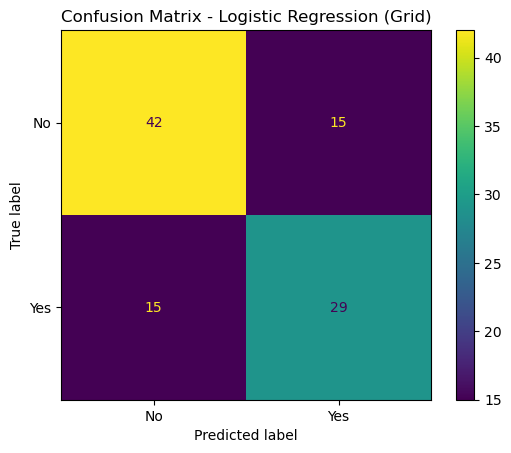

In [ ]:
# confusion matrix to show our model behaviour another way
disp = ConfusionMatrixDisplay.from_predictions(prediction_df['prediction'], prediction_df['is_performant'], 
                                                display_labels=['No', 'Yes'])
plt.title('Confusion Matrix - Logistic Regression (Grid)')
plt.grid(False)

Looking beyond the accuracy score, the matrix shows us that the model performs slightly better predicting the negative class (non-performant players) than the positive class (perfomant players).

In [148]:
# players who are in the hold-out set
prediction_df[['Player']].T
#name = 'James Harden'
#prediction_df[prediction_df['Player'].str.contains(name)]
#draft_df[draft_df['Player'].str.contains(name)]

,268,73,289,155,104,280,392,124,68,244,9,195,304,84,373,390,498,30,317,407,493,494,225,227,76,464,473,402,101,335,296,222,474,173,2,334,272,70,210,63,347,93,488,185,33,77,0,11,310,22,72,182,131,412,194,55,148,18,428,78,497,411,324,486,79,39,454,46,266,393,353,208,278,291,318,305,255,69,489,253,154,82,302,172,322,90,180,416,470,396,386,475,440,325,434,500,86,75,441,15,250
Player,Jordan Clarkson,Lazar Hayward,Rashad Vaughn,Kendall Marshall,Alec Burks,Willie Cauley-Stein,Jawun Evans,Jordan Williams,Damion James,T.J. Warren,Gerald Henderson,Nerlens Noel,Anthony Brown,Devin Ebanks,Justin Patton,Semi Ojeleye,Marial Shayok,Jon Brockman,Sir'Dominic Pointer,Jaron Blossomgame,Quinndary Weatherspoon,Jarrell Brantley,Erik Murphy,Lorenzo Brown,Armon Johnson,Cameron Johnson,Nassir Little,Edmond Sumner,Kemba Walker,DeAndre' Bembry,Tyus Jones,Mike Muscala,Dylan Windler,Orlando Johnson,James Harden,Caris LeVert,Alec Brown,Quincy Pondexter,Andre Roberson,Avery Bradley,Diamond Stone,Ryan Reid,Bol Bol,Kyle O'Quinn,Marcus Thornton,Terrico White,Blake Griffin,Earl Clark,Olivier Hanlan,Wayne Ellington,Daniel Orton,Justin Hamilton,Josh Harrellson,Wendell Carter Jr.,Alex Len,Paul George,Damian Lillard,Darren Collison,Moritz Wagner,Darington Hobson,Justin Wright-Foreman,Trae Young,Kris Dunn,Admiral Schofield,Andy Rautins,Jack McClinton,Kostas Antetokounmpo,John Wall,Markel Brown,Dwayne Bacon,Georges Niang,Tim Hardaway Jr.,D'Angelo Russell,Jerian Grant,Cady Lalanne,Rakeem Christmas,Josh Huestis,Dominique Jones,Isaiah Roby,P.J. Hairston,Jeremy Lamb,Jarvis Varnado,Montrezl Harrell,Draymond Green,Brandon Ingram,Luke Harangody,Mike Scott,Shai Gilgeous-Alexander,Brandon Clarke,Damyean Dotson,Davon Reed,Mfiondu Kabengele,Justin Jackson,Buddy Hield,Devonte' Graham,Jaylen Hands,Gani Lawal,Hassan Whiteside,Hamidou Diallo,Ty Lawson,Jordan Adams


In [187]:
# interactive scatter plot of our model prediction
fig = px.scatter(data_frame = prediction_df,       
           x = 'nba_DraftYear', y = 'prediction_proba', 
           color = 'correct',
           color_discrete_map = {1:  '#00CC96', 0:  '#EF553B'},
           symbol_sequence= ['x-open', 'circle'],
           symbol = 'correct',
           #labels = {'symbol' : 'correct prediction'},
           hover_name = 'Player', 
           hover_data = ['is_performant', 'prediction', 'porpag'],
           title = 'Which college player will be performant in the NBA?'
           )
fig.update_traces(marker=dict(size=10,
                              line=dict(width=2,
                                        color='DarkSlateGrey')))
fig.show()